In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 한 실행칸에 프린트 여러개 해도 다 출력시키도록 하는 코드.
from scipy.optimize import minimize
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# 1.

## (1) 일별 portfolio 비교

### Data gathering & preprocessing

##### 주의사항 : '한국은행경제통계시스템'에서 CD91일을 들고 와서 dataframe형태로 맨위의 행 몇개를 제거해 주어야함.
##### 주의사항을 지키지 않을 시, 가장 최신 데이터로부터 front fill 됨에 유의하기 바람.

In [2]:
_start = datetime(2009,1,1)
stock_list = ['005930.KS', '051910.KS', '005380.KS', '035420.KS', '017670.KS',
             '207940.KS', '068270.KS', '035720.KS', '006400.KS', '051900.KS']
data = pdr.get_data_yahoo(stock_list, start = _start)

종목들은 순서대로 삼성전자, LG화학, 현대자동차, NAVER, SK텔레콤, 삼성바이오로직스, 셀트리온, 카카오, 삼성SDI, LG생활건강이다.

In [3]:
data

Attributes     Adj Close                                               \
Symbols        005930.KS      051910.KS      005380.KS      035420.KS   
Date                                                                    
2009-01-02      1.705819   64533.707031   34970.972656   29473.808594   
2009-01-05      1.727595   67369.414062   37738.460938   29242.683594   
2009-01-06      1.807442   68056.851562   38577.101562   28202.386719   
2009-01-07      1.901807   69603.609375   41847.765625   30167.283203   
2009-01-08      1.843736   66939.757812   40170.503906   30051.767578   
...                  ...            ...            ...            ...   
2020-09-17  59500.000000  645000.000000  184000.000000  300500.000000   
2020-09-18  59300.000000  666000.000000  181000.000000  298000.000000   
2020-09-21  59200.000000  627000.000000  185000.000000  292000.000000   
2020-09-22  58200.000000  639000.000000  179500.000000  284500.000000   
2020-09-23  58600.000000  630000.000000  179500.000000  296500.000000   

Attributes                                                         \
Symbols         017670.KS 207940.KS      068270.KS      035720.KS   
Date                                                                
2009-01-02  130779.718750       NaN    9107.649414   28382.277344   
2009-01-05  127043.125000       NaN    9242.911133   28287.669922   
2009-01-06  127665.914062       NaN    9783.960938   29091.835938   
2009-01-07  127354.523438       NaN   10370.106445   30700.166016   
2009-01-08  127665.914062       NaN   10550.476562   30132.517578   
...                   ...       ...            ...            ...   
2020-09-17  244000.000000  757000.0  291500.000000  371000.000000   
2020-09-18  244000.000000  758000.0  291500.000000  373000.000000   
2020-09-21  240500.000000  740000.0  278500.000000  364500.000000   
2020-09-22  237500.000000  731000.0  268000.000000  353000.000000   
2020-09-23  233000.000000  705000.0  266000.000000  365500.000000   

Attributes                               ...      Volume             \
Symbols         006400.KS     051900.KS  ...   005930.KS  051910.KS   
Date                                     ...                          
2009-01-02   52165.308594  1.655669e+05  ...  22978400.0   521202.0   
2009-01-05   53085.328125  1.539400e+05  ...  30460450.0   493171.0   
2009-01-06   55845.398438  1.590558e+05  ...  45072450.0   614969.0   
2009-01-07   57961.457031  1.539400e+05  ...  41286200.0   415214.0   
2009-01-08   57685.445312  1.553352e+05  ...  30614600.0   788265.0   
...                   ...           ...  ...         ...        ...   
2020-09-17  445500.000000  1.508000e+06  ...  25108356.0  3408145.0   
2020-09-18  453000.000000  1.516000e+06  ...  18884571.0  1775061.0   
2020-09-21  446000.000000  1.497000e+06  ...  15140387.0  1239438.0   
2020-09-22  446500.000000  1.473000e+06  ...  20830381.0  1209481.0   
2020-09-23  436500.000000  1.455000e+06  ...  20019143.0  1264951.0   

Attributes                                                                 \
Symbols     005380.KS  035420.KS 017670.KS 207940.KS  068270.KS 035720.KS   
Date                                                                        
2009-01-02  1480986.0   579912.0  292783.0       NaN  1551873.0  276419.0   
2009-01-05  3081708.0   511429.0  609214.0       NaN  3119329.0  165820.0   
2009-01-06  2926386.0  1778075.0  500783.0       NaN  3276530.0  204631.0   
2009-01-07  3652130.0  1573188.0  581810.0       NaN  5081757.0  249212.0   
2009-01-08  3164452.0  1863356.0  542738.0       NaN  1690516.0  179786.0   
...               ...        ...       ...       ...        ...       ...   
2020-09-17  4383978.0   823516.0  182401.0  121310.0   685924.0  617702.0   
2020-09-18  2584103.0   750488.0  220441.0   64797.0   754705.0  495271.0   
2020-09-21  3133848.0   656024.0  214090.0   96630.0  1074281.0  530255.0   
2020-09-22  3042046.0   864846.0  236983.0  174966.0  1337964.0  880318.0   
2020-09-23  34

In [4]:
data = data.xs('Close', axis = 1)
data.head()

Symbols,005930.KS,051910.KS,005380.KS,035420.KS,017670.KS,207940.KS,068270.KS,035720.KS,006400.KS,051900.KS
Date,,,,,,,,,,
2009-01-02,9400.0,75100.0,41700.0,31255.900391,210000.0,NaN,9164.730469,30000.0,56700.0,178000.0
2009-01-05,9520.0,78400.0,45000.0,31010.800781,204000.0,NaN,9300.839844,29900.0,57700.0,165500.0
2009-01-06,9960.0,79200.0,46000.0,29907.599609,205000.0,NaN,9845.280273,30750.0,60700.0,171000.0
2009-01-07,10480.0,81000.0,49900.0,31991.300781,204500.0,NaN,10435.099609,32450.0,63000.0,165500.0
2009-01-08,10160.0,77900.0,47900.0,31868.800781,205000.0,NaN,10616.599609,31850.0,62700.0,167000.0


In [5]:
data.describe()

Symbols,005930.KS,051910.KS,005380.KS,035420.KS,017670.KS,207940.KS,068270.KS,035720.KS,006400.KS,051900.KS
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,945.000000,2896.000000,2896.000000,2896.000000,2.896000e+03
mean,30614.036602,307928.694751,161952.537983,112366.739422,211811.813881,389142.328042,89502.387459,110213.760359,165679.765193,7.543384e+05
std,13239.047870,92893.414149,50302.955063,57568.968111,42959.004758,157424.215379,83397.147216,50432.531391,64760.540487,3.685041e+05
min,8840.000000,74600.000000,41700.000000,29785.000000,120500.000000,142000.000000,9164.730469,23200.000000,54500.000000,1.480000e+05
25%,19920.000000,260000.000000,128375.000000,54299.500000,173500.000000,287500.000000,32348.800781,83100.000000,126500.000000,4.698750e+05
50%,26840.000000,302500.000000,152000.000000,123100.000000,218500.000000,381000.000000,42273.451172,103900.000000,151500.000000,6.400000e+05
75%,43900.000000,353500.000000,209500.000000,153600.000000,246000.000000,452000.000000,134472.000000,127500.000000,191000.000000,1.080000e+06
max,62400.000000,768000.000000,268500.000000,339000.000000,301000.000000,843000.000000,348740.000000,412000.000000,488000.000000,1.573000e+06


In [6]:
#kospi = data.DataReader("^KS11", "yahoo", datetime(2009, 1, 1))
kospi = pdr.data.get_data_yahoo("^KS11", datetime(2009, 1, 1))
kospi

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,1157.400024,1118.839966,1132.869995,1157.400024,340600.0,1157.400024
2009-01-05,1185.219971,1166.660034,1180.979980,1173.569946,414600.0,1173.569946
2009-01-06,1203.589966,1179.939941,1183.520020,1194.280029,444000.0,1194.280029
2009-01-07,1228.560059,1195.199951,1198.849976,1228.170044,568400.0,1228.170044
2009-01-08,1218.430054,1195.150024,1212.699951,1205.699951,472200.0,1205.699951
...,...,...,...,...,...,...
2020-09-17,2437.020020,2398.689941,2430.770020,2406.169922,853700.0,2406.169922
2020-09-18,2417.810059,2396.330078,2413.530029,2412.399902,756500.0,2412.399902
2020-09-21,2427.169922,2379.379883,2412.439941,2389.389893,1042000.0,2389.389893


In [7]:
kospi = kospi[['Adj Close']]
kospi

,Adj Close
Date,
2009-01-02,1157.400024
2009-01-05,1173.569946
2009-01-06,1194.280029
2009-01-07,1228.170044
2009-01-08,1205.699951
...,...
2020-09-17,2406.169922
2020-09-18,2412.399902
2020-09-21,2389.389893


,date,rate
0,2009.1.2,3.93
1,2009.1.5,3.92
2,2009.1.6,3.92
3,2009.1.7,3.92
4,2009.1.8,3.25


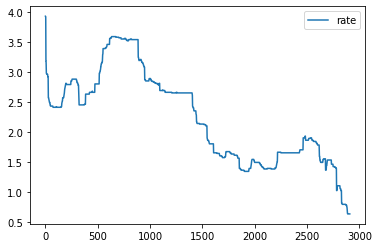

In [8]:
data_cd = pd.read_csv('./CD91.csv')
data_cd.head()
data_cd.plot()

In [9]:
data_cd.dtypes

date     object
rate    float64
dtype: object

In [10]:
data_cd['rate'] = data_cd['rate'] / 100 / 365
data_cd['date'] = data_cd['date'].apply(lambda x: pd.to_datetime(x, format='%Y.%m.%d'))
data_cd.set_index(data_cd['date'], inplace = True)
data_cd.drop(['date'], axis = 1, inplace = True)
data_cd

,rate
date,
2009-01-02,0.000108
2009-01-05,0.000107
2009-01-06,0.000107
2009-01-07,0.000107
2009-01-08,0.000089
...,...
2020-09-11,0.000017
2020-09-14,0.000017
2020-09-15,0.000017


In [11]:
for c in list(data.columns):
    data[c] = np.log(data[c]/data[c].shift(1))

In [12]:
data

Symbols,005930.KS,051910.KS,005380.KS,035420.KS,017670.KS,207940.KS,068270.KS,035720.KS,006400.KS,051900.KS
Date,,,,,,,,,,
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,0.012685,0.043003,0.076161,-0.007873,-0.028988,NaN,0.014742,-0.003339,0.017483,-0.072812
2009-01-06,0.045182,0.010152,0.021979,-0.036223,0.004890,NaN,0.056887,0.028032,0.050687,0.032692
2009-01-07,0.050892,0.022473,0.081380,0.067351,-0.002442,NaN,0.058183,0.053810,0.037191,-0.032692
2009-01-08,-0.031010,-0.039023,-0.040905,-0.003837,0.002442,NaN,0.017244,-0.018663,-0.004773,0.009023
...,...,...,...,...,...,...,...,...,...,...
2020-09-17,-0.024898,-0.063084,0.002721,-0.021400,0.004107,-0.024789,-0.018692,-0.016043,-0.008939,0.001327
2020-09-18,-0.003367,0.032039,-0.016439,-0.008354,0.000000,0.001320,0.000000,0.005376,0.016695,0.005291
2020-09-21,-0.001688,-0.060343,0.021859,-0.020340,-0.014448,-0.024033,-0.045622,-0.023052,-0.015573,-0.012612


In [13]:
data = data.join(data_cd, how='left')
data.fillna(method = 'ffill', inplace = True)
data.fillna(method = 'bfill', inplace = True)
data.dropna(inplace = True)
kospi = kospi.join(data_cd, how = 'left')
kospi.fillna(method = 'ffill', inplace = True)
kospi.fillna(method = 'bfill', inplace = True)
kospi.dropna(inplace = True)
data

,005930.KS,051910.KS,005380.KS,035420.KS,017670.KS,207940.KS,068270.KS,035720.KS,006400.KS,051900.KS,rate
Date,,,,,,,,,,,
2009-01-02,0.012685,0.043003,0.076161,-0.007873,-0.028988,0.114692,0.014742,-0.003339,0.017483,-0.072812,0.000108
2009-01-05,0.012685,0.043003,0.076161,-0.007873,-0.028988,0.114692,0.014742,-0.003339,0.017483,-0.072812,0.000107
2009-01-06,0.045182,0.010152,0.021979,-0.036223,0.004890,0.114692,0.056887,0.028032,0.050687,0.032692,0.000107
2009-01-07,0.050892,0.022473,0.081380,0.067351,-0.002442,0.114692,0.058183,0.053810,0.037191,-0.032692,0.000107
2009-01-08,-0.031010,-0.039023,-0.040905,-0.003837,0.002442,0.114692,0.017244,-0.018663,-0.004773,0.009023,0.000089
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,-0.024898,-0.063084,0.002721,-0.021400,0.004107,-0.024789,-0.018692,-0.016043,-0.008939,0.001327,0.000017
2020-09-18,-0.003367,0.032039,-0.016439,-0.008354,0.000000,0.001320,0.000000,0.005376,0.016695,0.005291,0.000017
2020-09-21,-0.001688,-0.060343,0.021859,-0.020340,-0.014448,-0.024033,-0.045622,-0.023052,-0.015573,-0.012612,0.000017


In [14]:
kospi['log_ret'] = np.log(kospi['Adj Close'] / kospi['Adj Close'].shift(1))

### 오늘부터 10년전의 데이터만을 사용한다!

In [15]:
today = datetime(datetime.today().year, datetime.today().month, datetime.today().day)
ten_years_ago = today + relativedelta(years = -10)

In [16]:
kospi = kospi[kospi.index >= ten_years_ago]
kospi['rate'] = kospi['rate']/365
kospi['EER'] = kospi['log_ret'] - kospi['rate']
kospi

,Adj Close,rate,log_ret,EER
Date,,,,
2010-09-24,1846.599976,1.996622e-07,0.007594,0.007594
2010-09-27,1860.829956,1.996622e-07,0.007677,0.007676
2010-09-28,1855.969971,1.996622e-07,-0.002615,-0.002615
2010-09-29,1866.449951,1.996622e-07,0.005631,0.005631
2010-09-30,1872.810059,1.996622e-07,0.003402,0.003402
...,...,...,...,...
2020-09-17,2406.169922,4.728842e-08,-0.012288,-0.012288
2020-09-18,2412.399902,4.728842e-08,0.002586,0.002586
2020-09-21,2389.389893,4.728842e-08,-0.009584,-0.009584


In [17]:
data_cd2 = data[['rate']].copy()
data_cd2

,rate
Date,
2009-01-02,0.000108
2009-01-05,0.000107
2009-01-06,0.000107
2009-01-07,0.000107
2009-01-08,0.000089
...,...
2020-09-17,0.000017
2020-09-18,0.000017
2020-09-21,0.000017


In [18]:
data = data[data.index >= ten_years_ago]
for i in data.columns:
    data[i] = data[i] - data['rate']
data.drop('rate', axis = 1, inplace = True)

In [19]:
EER_kospi = kospi[['EER']]

In [20]:
sigma=0.0352

In [21]:
def train_data(test_date):
    _start_date = test_date + relativedelta(years = -2)
    _end_date = test_date
    df = data[(data.index >= _start_date) & (data.index <= _end_date)]
    return df

In [22]:
date_list = data.index
eight_years_ago = today + relativedelta(years = -8)
test_date_list = date_list[date_list >= eight_years_ago]
test_date_list

DatetimeIndex(['2012-09-24', '2012-09-25', '2012-09-26', '2012-09-27',
               '2012-09-28', '2012-10-02', '2012-10-04', '2012-10-05',
               '2012-10-08', '2012-10-09',
               ...
               '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-21',
               '2020-09-22', '2020-09-23'],
              dtype='datetime64[ns]', name='Date', length=1962, freq=None)

In [23]:
def weight_lasso(x):
    global df
    rc = x[0] # scalar
    w = x[1:] # (p, 1)
    wr = df.to_numpy() @ w
    return (rc - wr.mean())**2

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

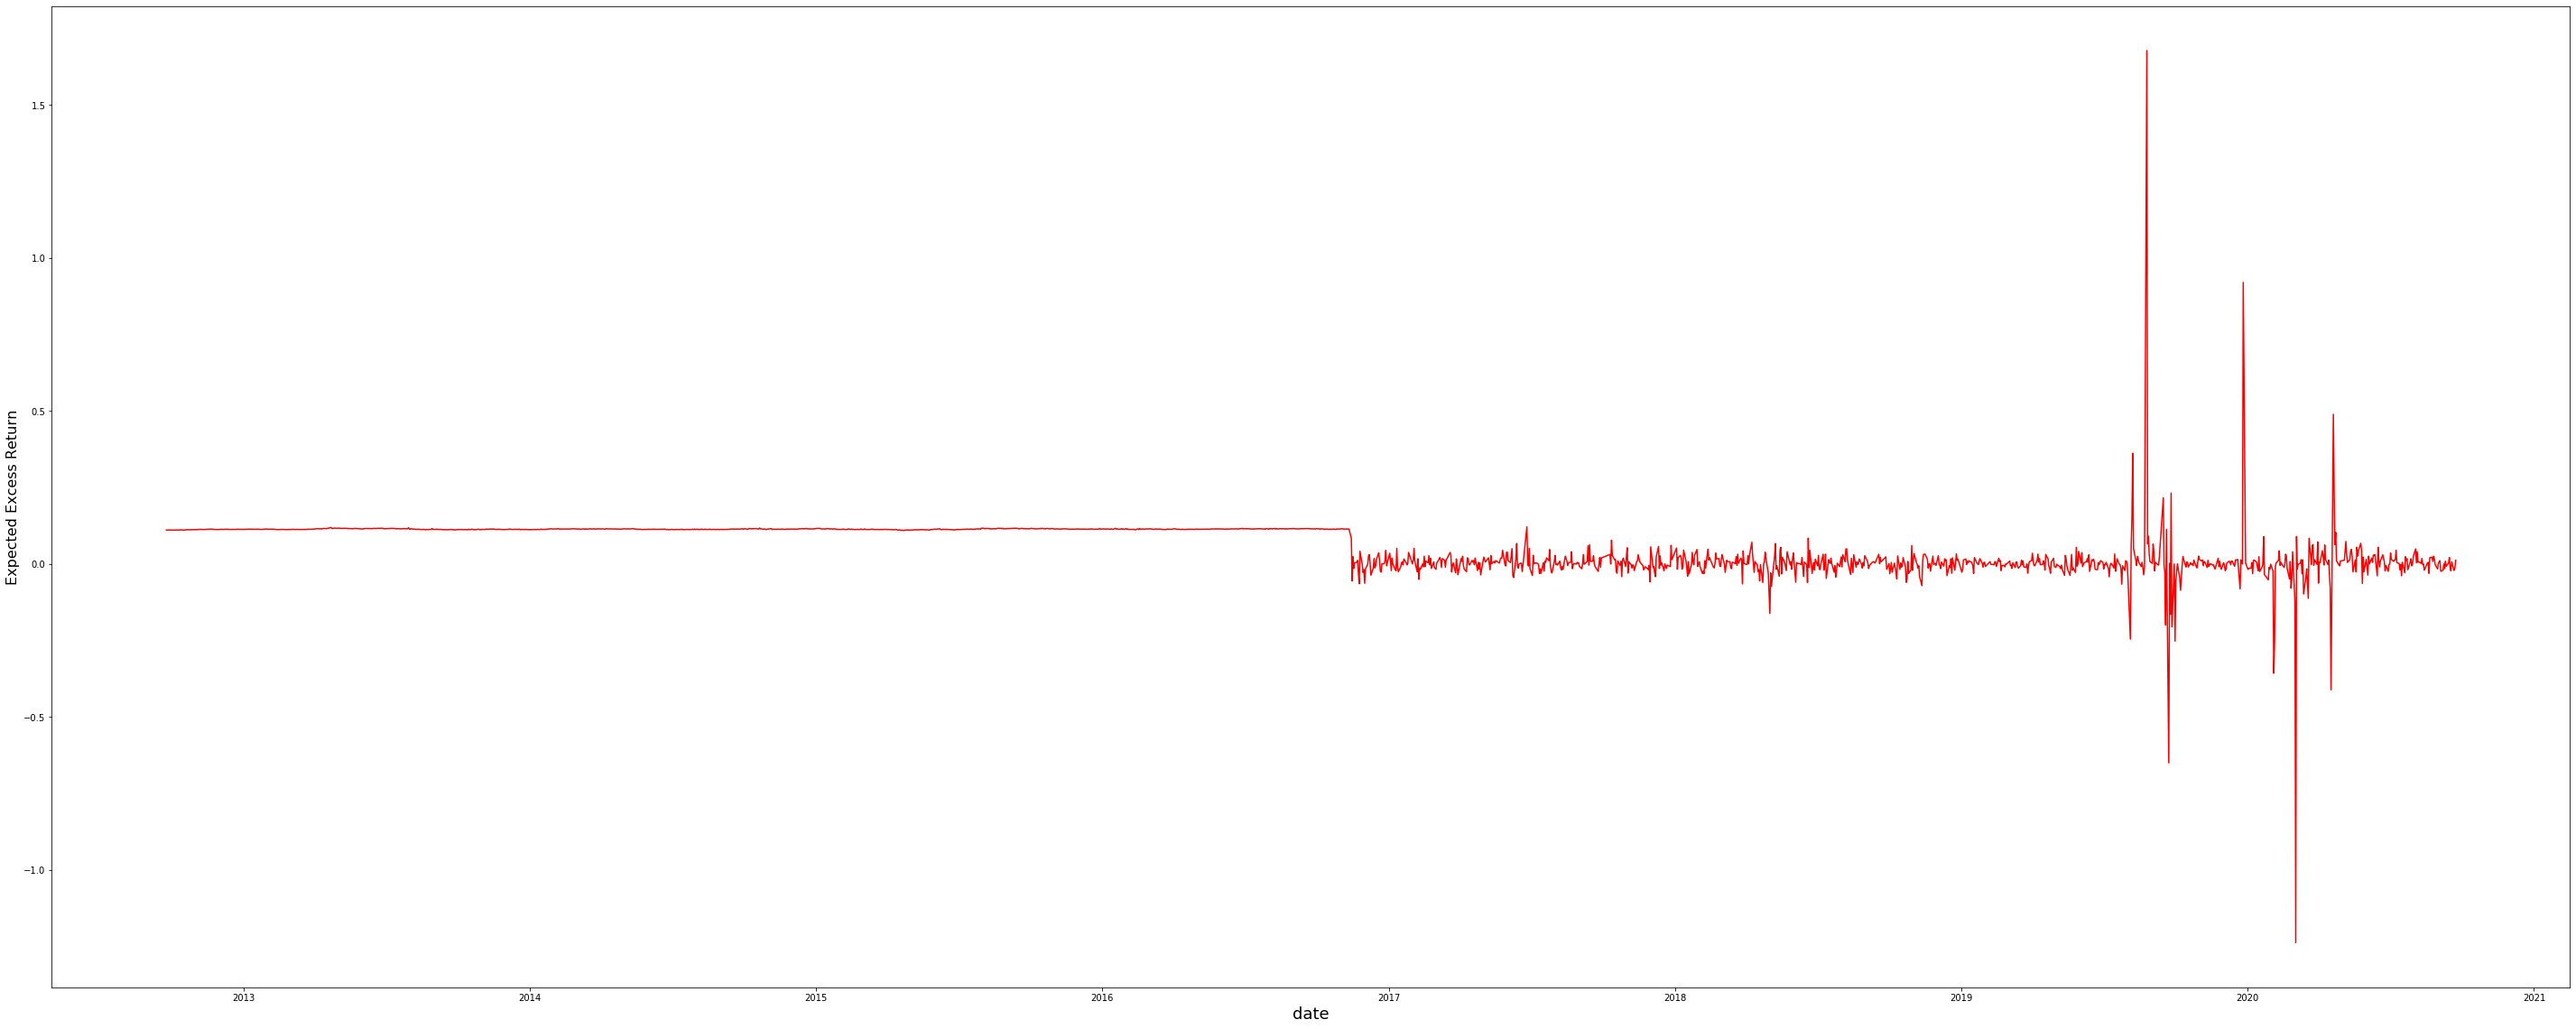

sharpe_ratio: 0.7214954921950096


In [24]:
def Lasso_method():
    global df
    EER_lasso = []
    for i in range(len(test_date_list)): 
        #print(test_date_list[i])
        df = train_data(test_date_list[i])
        vcov = df.cov().values
        mu = df.mean(axis = 0)
        mu = np.array(mu.values.tolist()).reshape(-1,1)
        n = len(df)
        p = len(df.columns)
        theta = np.abs( (mu.T @ np.linalg.inv(vcov) @ mu) - p/(n-p) ) / (n/(n-p))
        Rc = sigma * (1+theta)/np.sqrt(theta)
        y = np.ones((n, 1)) * Rc
        lasso = linear_model.Lasso(alpha=0)
        _coef = lasso.fit(df.to_numpy(), y).coef_
        Rc = Rc.reshape(-1)
        bnds1 = [(Rc[0], Rc[0])] + [(None, None) for x in range(p)]
        _input = np.concatenate((Rc, _coef), axis = 0)
        res = minimize(weight_lasso, _input.tolist(), bounds = bnds1)
        w = res.x[1:]
        w = w/w.sum()
        test_data = data.loc[test_date_list[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_lasso.append(er)
    return np.array(EER_lasso)

eer_lasso = Lasso_method()
eer_lasso = eer_lasso.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list, eer_lasso, color = 'red')
plt.show()
sharpe_ratio_lasso = eer_lasso.mean()/eer_lasso.std()
print('sharpe_ratio:', sharpe_ratio_lasso)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

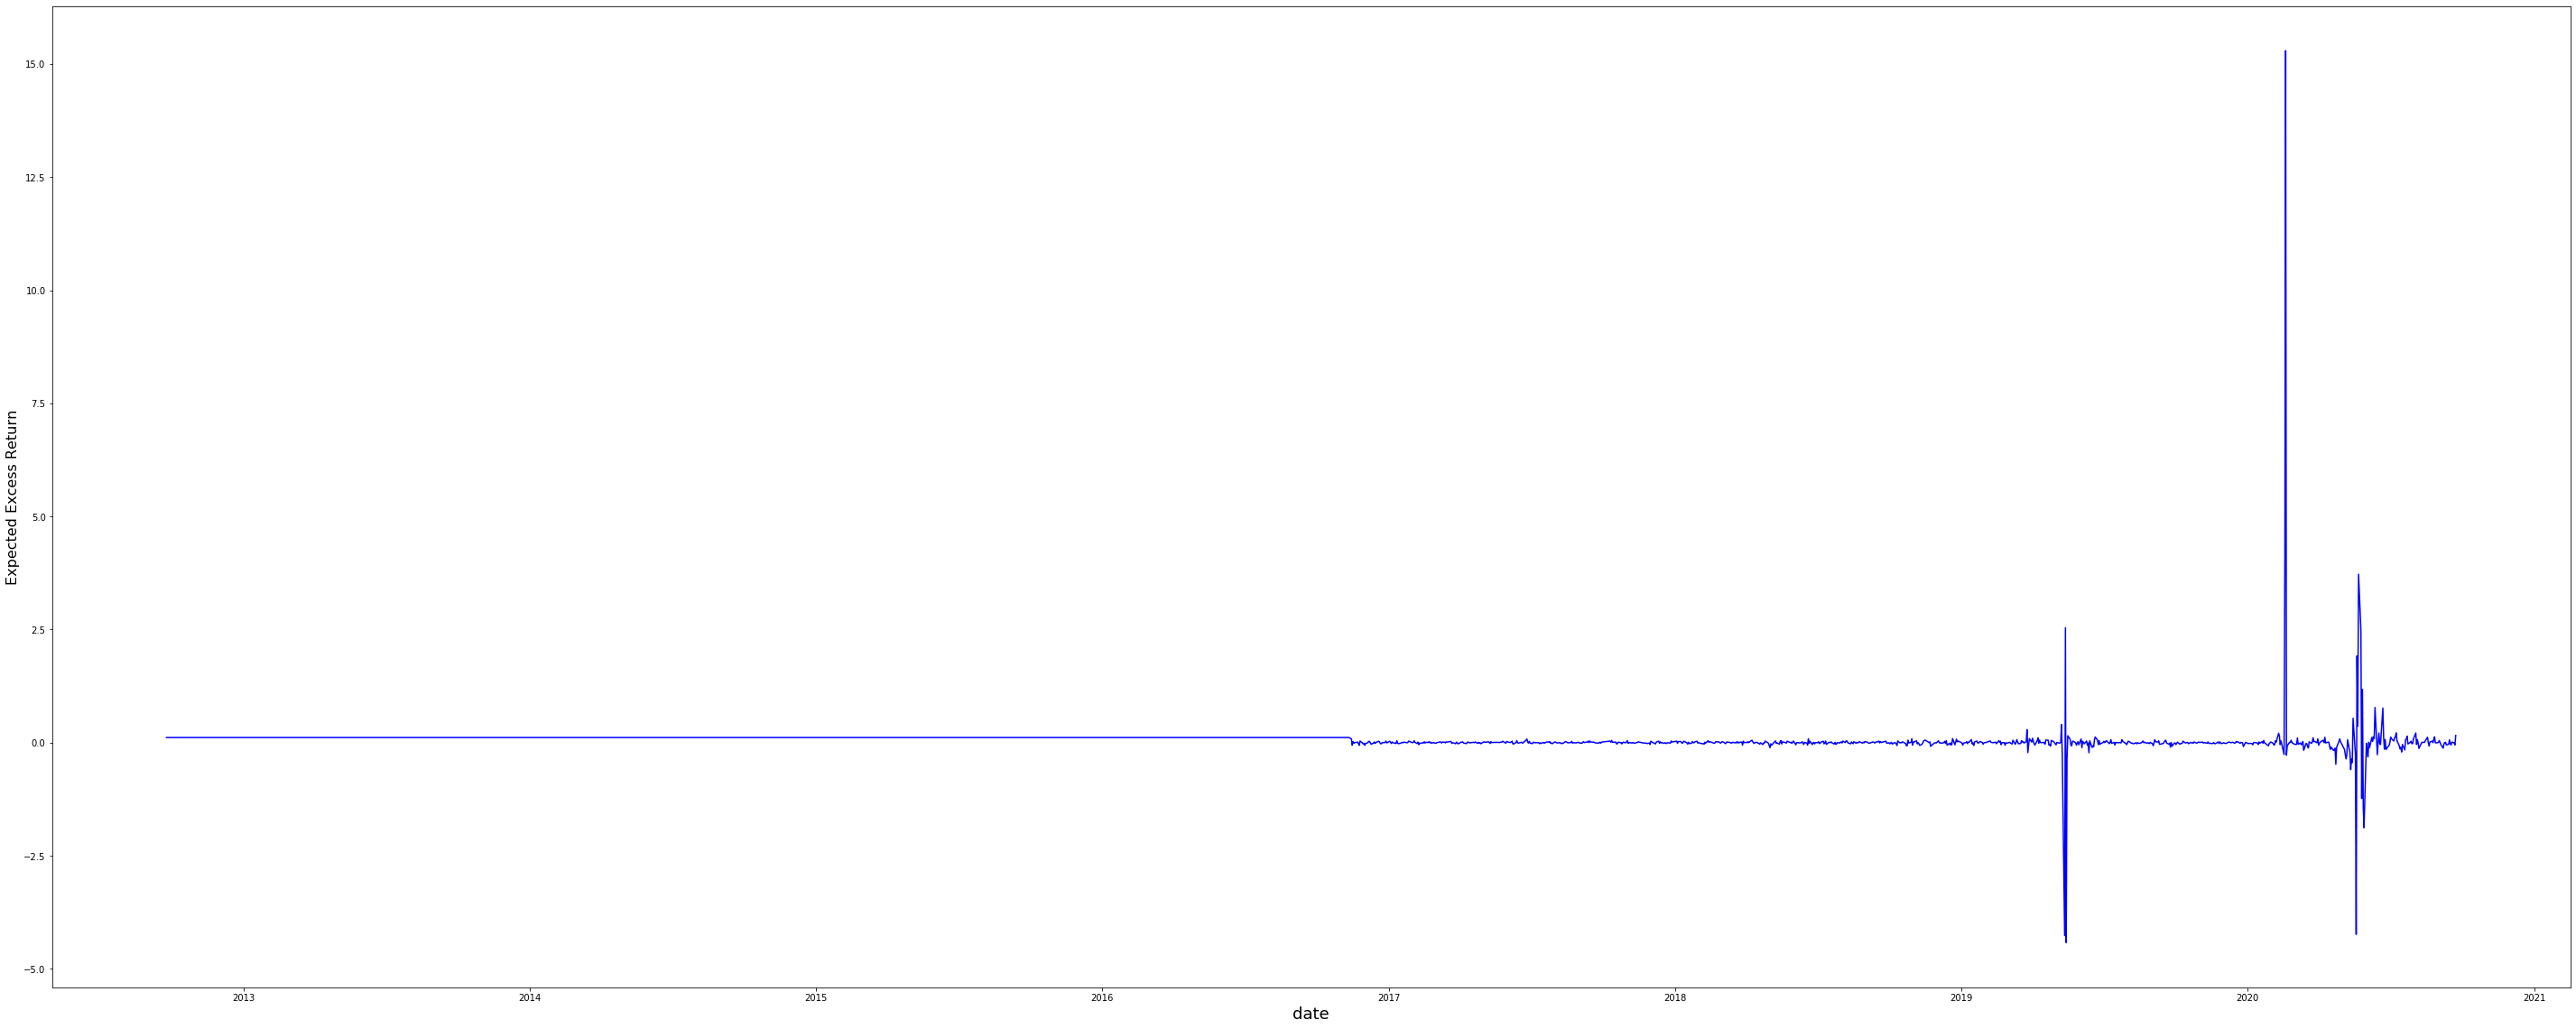

sharpe_ratio: 0.15578179516202154


In [25]:
def plug_in_method():
    EER_plug = []
    for i in range(len(test_date_list)):
        df = train_data(test_date_list[i]) # (n, p)
        vcov = df.cov().values # (p, p)
        mu = df.mean(axis = 0) # (p)
        mu = np.array(mu.values.tolist()).reshape(-1,1) # (p, 1)
        w = sigma / np.sqrt( mu.T @ np.linalg.inv(vcov) @ mu ) * ( np.linalg.inv(vcov) @ mu )
        # (1, p) @ (p, p) @ (p, 1) // (p, p) @ (p, 1)
        w = w/w.sum()
        test_data = data.loc[test_date_list[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_plug.append(er)
    return np.array(EER_plug)

eer_plug= plug_in_method()
eer_plug = eer_plug.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list, eer_plug, color = 'blue')
plt.show()
sharpe_ratio_plug = eer_plug.mean()/eer_plug.std()
print('sharpe_ratio:', sharpe_ratio_plug)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

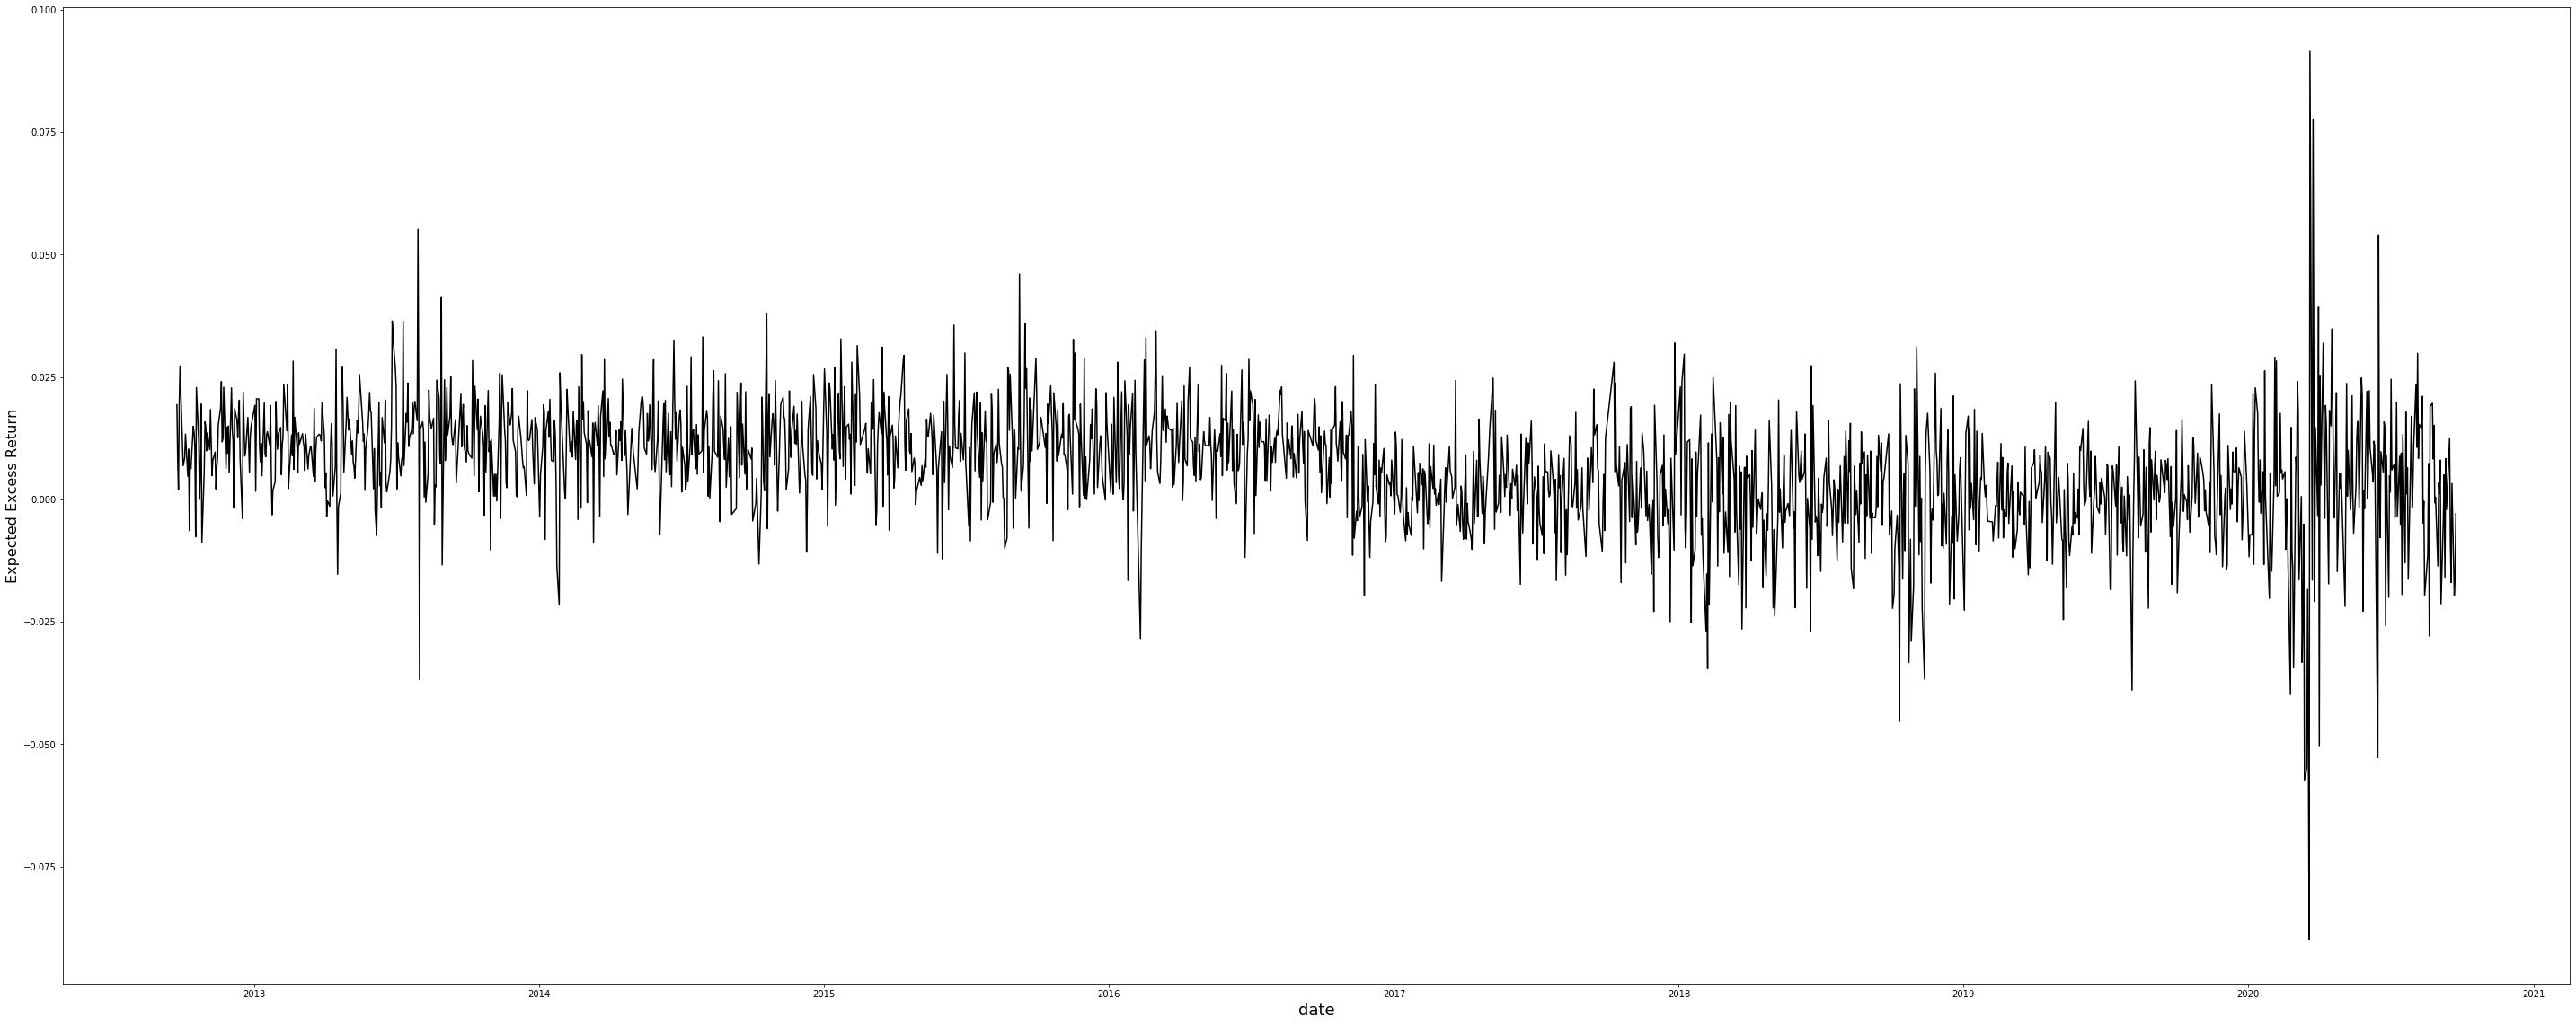

sharpe_ratio: 0.5242426079133936


In [26]:
def equal_weight_method():
    EER_equal = []
    for i in range(len(test_date_list)):
        df = train_data(test_date_list[i])
        w = np.ones(len(df.columns)) * (1/len(df.columns))
        test_data = data.loc[test_date_list[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_equal.append(er)
    return np.array(EER_equal)

eer_equal= equal_weight_method()
eer_equal = eer_equal.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list, eer_equal, color = 'black')
plt.show()
sharpe_ratio_equal = eer_equal.mean()/eer_equal.std()
print('sharpe_ratio:', sharpe_ratio_equal)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

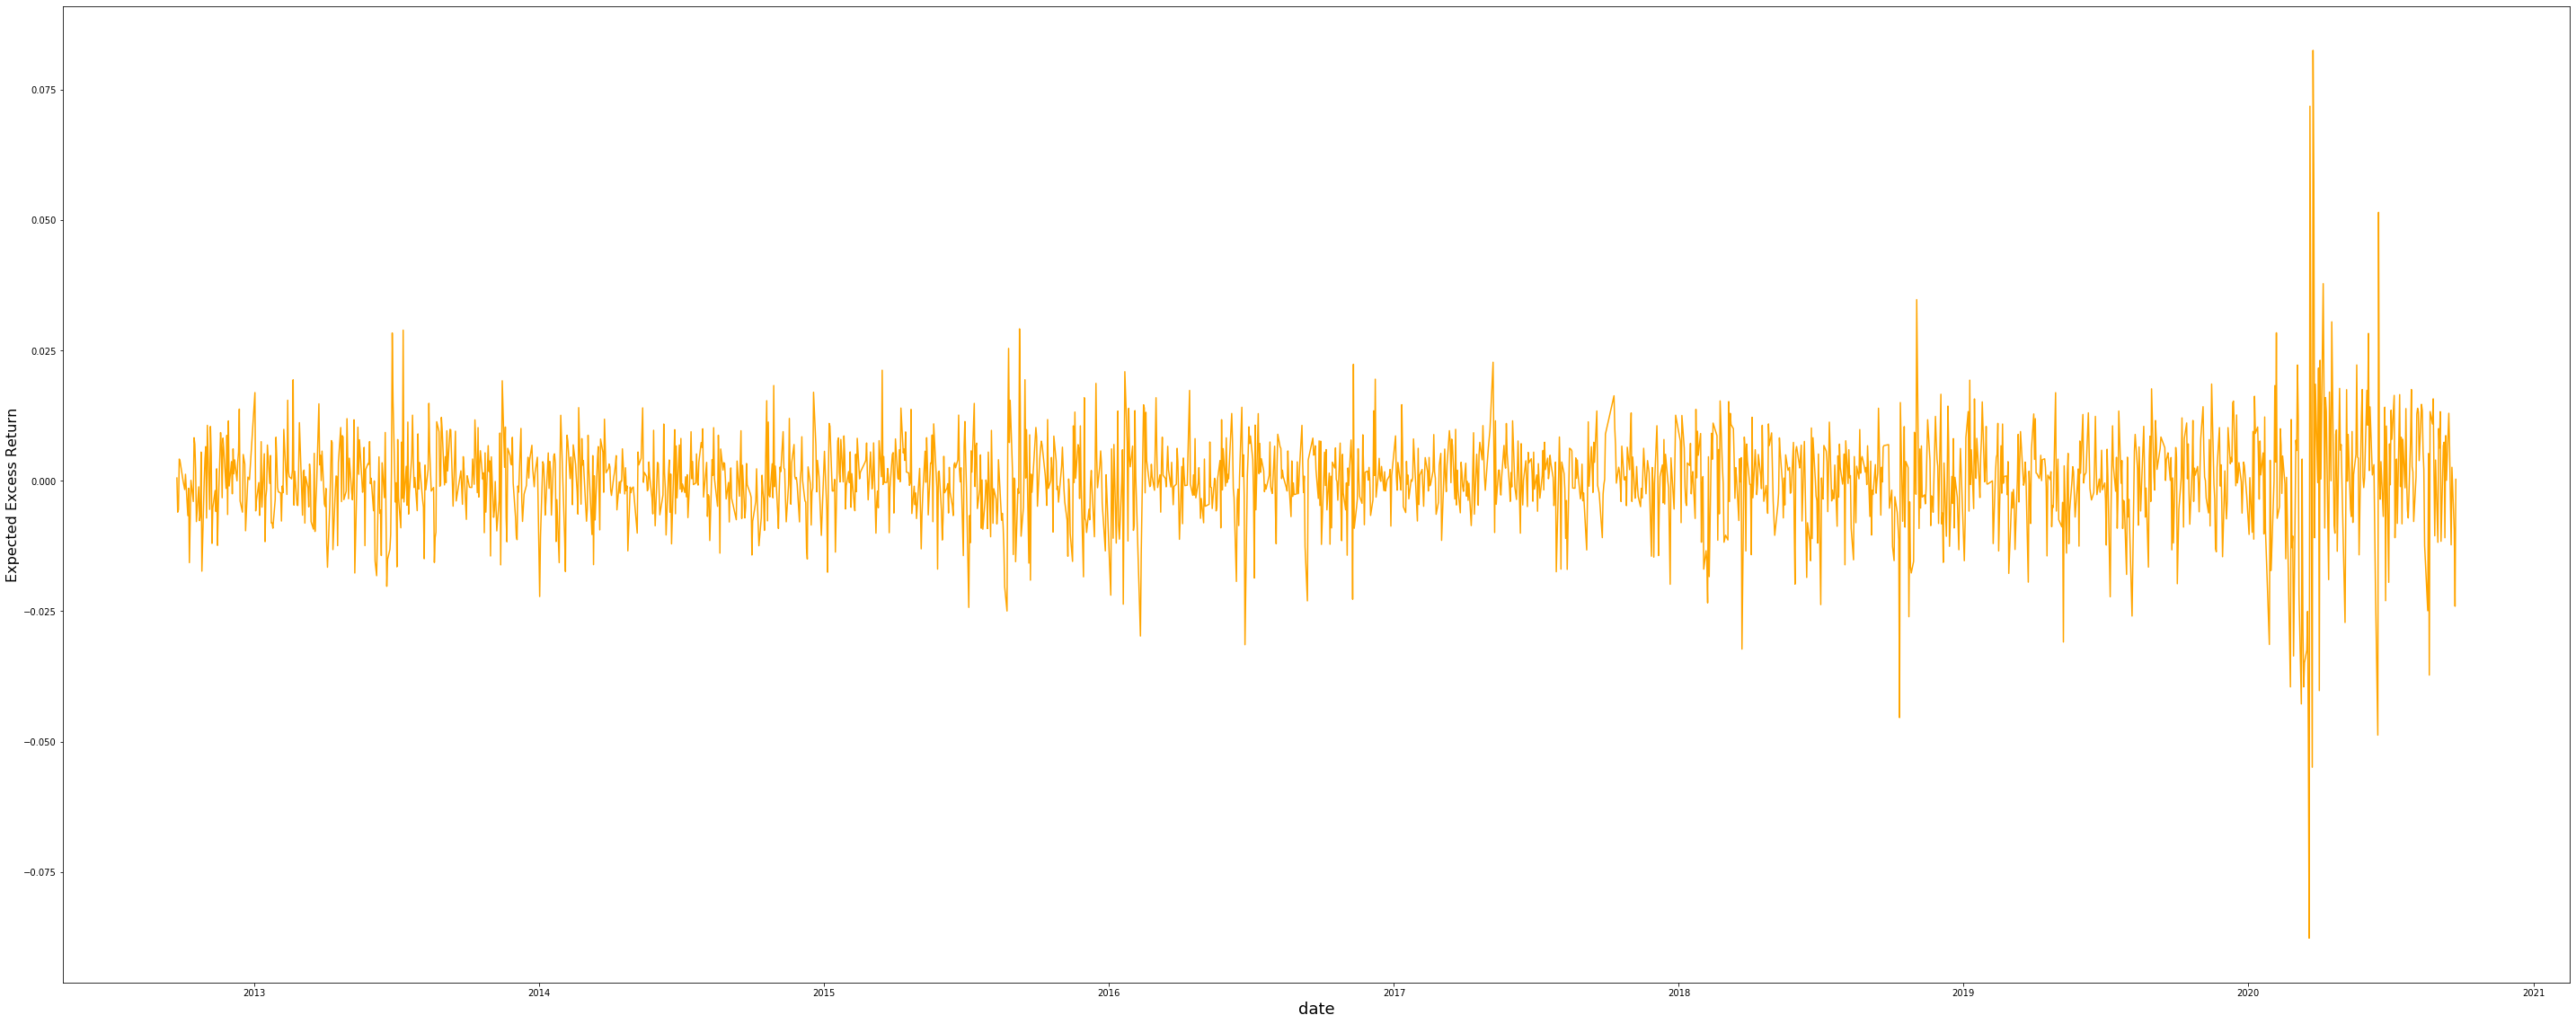

sharpe_ratio: 0.008281647488673936


In [27]:
# KOSPI
eer_kospi_df = EER_kospi.loc[test_date_list[0]:]
eer_kospi = eer_kospi_df.to_numpy().reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(eer_kospi_df.index, eer_kospi, color = 'orange')
plt.show()
sharpe_ratio_kospi = eer_kospi.mean()/eer_kospi.std()
print('sharpe_ratio:', sharpe_ratio_kospi)

2012-09-24 00:00:00
2012-09-25 00:00:00
2012-09-26 00:00:00
2012-09-27 00:00:00
2012-09-28 00:00:00
2012-10-02 00:00:00
2012-10-04 00:00:00
2012-10-05 00:00:00
2012-10-08 00:00:00
2012-10-09 00:00:00
2012-10-10 00:00:00
2012-10-11 00:00:00
2012-10-12 00:00:00
2012-10-15 00:00:00
2012-10-16 00:00:00
2012-10-17 00:00:00
2012-10-18 00:00:00
2012-10-19 00:00:00
2012-10-22 00:00:00
2012-10-23 00:00:00
2012-10-24 00:00:00
2012-10-25 00:00:00
2012-10-26 00:00:00
2012-10-29 00:00:00
2012-10-30 00:00:00
2012-10-31 00:00:00
2012-11-01 00:00:00
2012-11-02 00:00:00
2012-11-05 00:00:00
2012-11-06 00:00:00
2012-11-07 00:00:00
2012-11-08 00:00:00
2012-11-09 00:00:00
2012-11-12 00:00:00
2012-11-13 00:00:00
2012-11-14 00:00:00
2012-11-15 00:00:00
2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-22 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00


2014-05-26 00:00:00
2014-05-27 00:00:00
2014-05-28 00:00:00
2014-05-29 00:00:00
2014-05-30 00:00:00
2014-06-02 00:00:00
2014-06-03 00:00:00
2014-06-05 00:00:00
2014-06-09 00:00:00
2014-06-10 00:00:00
2014-06-11 00:00:00
2014-06-12 00:00:00
2014-06-13 00:00:00
2014-06-16 00:00:00
2014-06-17 00:00:00
2014-06-18 00:00:00
2014-06-19 00:00:00
2014-06-20 00:00:00
2014-06-23 00:00:00
2014-06-24 00:00:00
2014-06-25 00:00:00
2014-06-26 00:00:00
2014-06-27 00:00:00
2014-06-30 00:00:00
2014-07-01 00:00:00
2014-07-02 00:00:00
2014-07-03 00:00:00
2014-07-04 00:00:00
2014-07-07 00:00:00
2014-07-08 00:00:00
2014-07-09 00:00:00
2014-07-10 00:00:00
2014-07-11 00:00:00
2014-07-14 00:00:00
2014-07-15 00:00:00
2014-07-16 00:00:00
2014-07-17 00:00:00
2014-07-18 00:00:00
2014-07-21 00:00:00
2014-07-22 00:00:00
2014-07-23 00:00:00
2014-07-24 00:00:00
2014-07-25 00:00:00
2014-07-28 00:00:00
2014-07-29 00:00:00
2014-07-30 00:00:00
2014-07-31 00:00:00
2014-08-01 00:00:00
2014-08-04 00:00:00
2014-08-05 00:00:00


2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-29 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-25 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00


2017-09-19 00:00:00
2017-09-20 00:00:00
2017-09-21 00:00:00
2017-09-25 00:00:00
2017-09-26 00:00:00
2017-09-27 00:00:00
2017-09-28 00:00:00
2017-09-29 00:00:00
2017-10-10 00:00:00
2017-10-11 00:00:00
2017-10-12 00:00:00
2017-10-13 00:00:00
2017-10-16 00:00:00
2017-10-17 00:00:00
2017-10-18 00:00:00
2017-10-19 00:00:00
2017-10-20 00:00:00
2017-10-23 00:00:00
2017-10-24 00:00:00
2017-10-25 00:00:00
2017-10-26 00:00:00
2017-10-27 00:00:00
2017-10-30 00:00:00
2017-10-31 00:00:00
2017-11-01 00:00:00
2017-11-02 00:00:00
2017-11-03 00:00:00
2017-11-06 00:00:00
2017-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2017-11-10 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-17 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-24 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00


2019-06-11 00:00:00
2019-06-12 00:00:00
2019-06-13 00:00:00
2019-06-14 00:00:00
2019-06-17 00:00:00
2019-06-18 00:00:00
2019-06-19 00:00:00
2019-06-20 00:00:00
2019-06-21 00:00:00
2019-06-24 00:00:00
2019-06-25 00:00:00
2019-06-26 00:00:00
2019-06-27 00:00:00
2019-06-28 00:00:00
2019-07-01 00:00:00
2019-07-02 00:00:00
2019-07-03 00:00:00
2019-07-04 00:00:00
2019-07-05 00:00:00
2019-07-08 00:00:00
2019-07-09 00:00:00
2019-07-10 00:00:00
2019-07-11 00:00:00
2019-07-12 00:00:00
2019-07-15 00:00:00
2019-07-16 00:00:00
2019-07-17 00:00:00
2019-07-18 00:00:00
2019-07-19 00:00:00
2019-07-22 00:00:00
2019-07-23 00:00:00
2019-07-24 00:00:00
2019-07-25 00:00:00
2019-07-26 00:00:00
2019-07-29 00:00:00
2019-07-30 00:00:00
2019-07-31 00:00:00
2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00
2019-08-07 00:00:00
2019-08-08 00:00:00
2019-08-09 00:00:00
2019-08-12 00:00:00
2019-08-13 00:00:00
2019-08-14 00:00:00
2019-08-16 00:00:00
2019-08-19 00:00:00
2019-08-20 00:00:00


<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

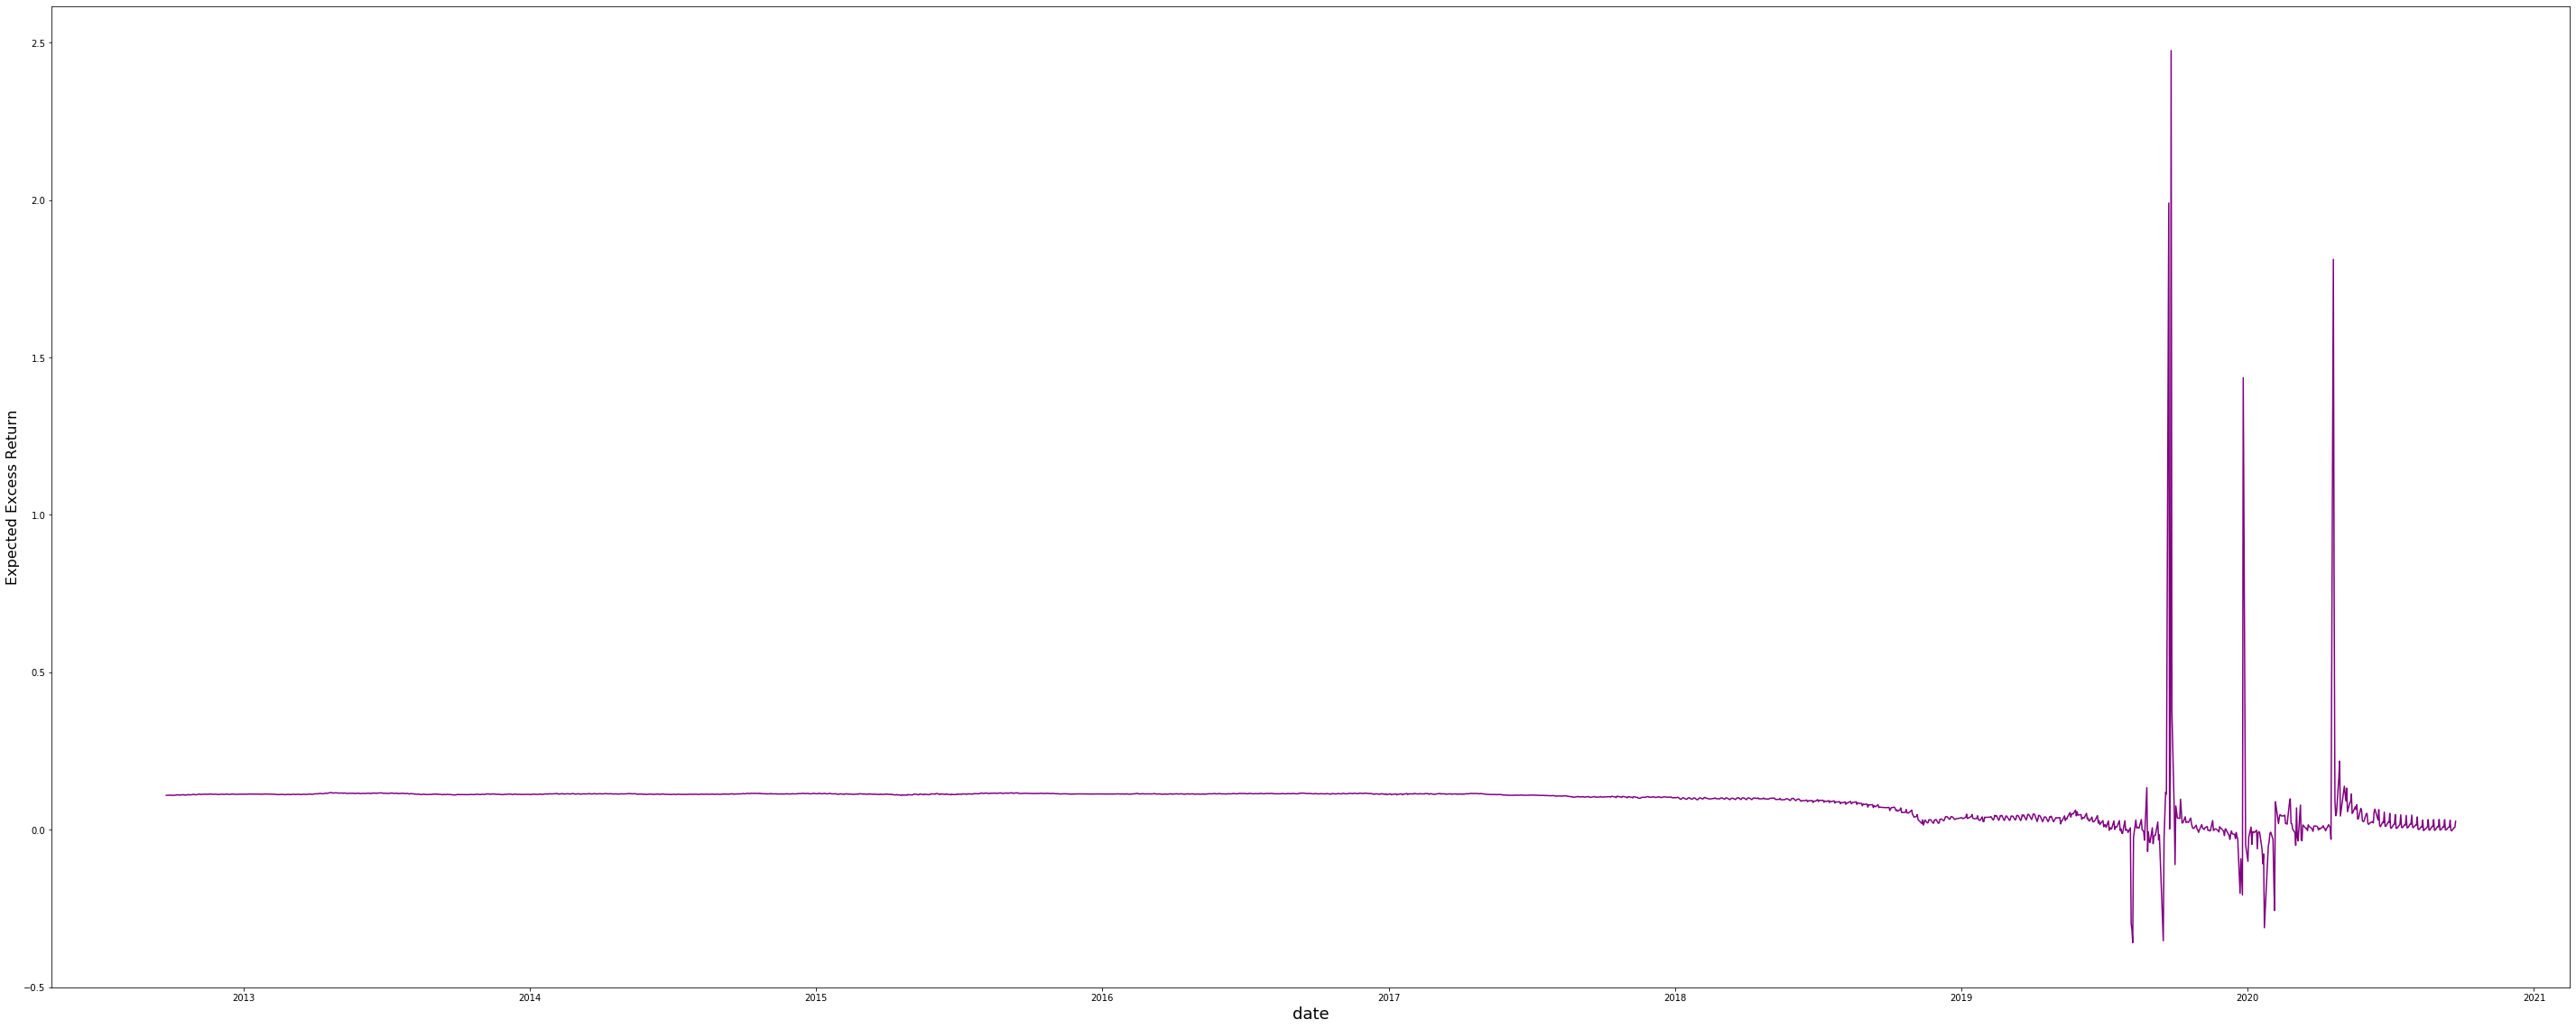

sharpe_ratio: 0.9313169869109026


In [28]:
def Shrinkage_method():
    EER_shrink = []
    for i in range(len(test_date_list)):
        print(test_date_list[i])
        df = train_data(test_date_list[i]) # (n, p)
        vcov = df.cov().values # (p, p)
        mu = df.mean(axis = 0) # (p)
        mu = np.array(mu.values.tolist()).reshape(-1,1) # (p, 1)
        n = len(df)
        p = len(df.columns)

        F = np.diag(vcov).sum()/p * np.eye(p)
        up = 0
        for i in range(n):
            X = df.iloc[i].values
            temp_up = X @ X.T - vcov
            temp_up = (temp_up**2).sum()
            up += temp_up
        vcov2 = vcov @ vcov
        down = n**2 * ( np.diag(vcov2).sum() - np.diag(vcov).sum()**2/p )
        pi = min(up/down, 1)
        sigma_s = (1-pi)*vcov + pi*F
        w = sigma/np.sqrt( mu.T @ sigma_s @ mu ) * (np.linalg.inv(sigma_s) @ mu)
        w = w/w.sum()
        
        test_data = data.loc[test_date_list[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_shrink.append(er)
    return np.array(EER_shrink)

eer_shrink = Shrinkage_method()
eer_shrink = eer_shrink.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list, eer_shrink, color = 'purple')
plt.show()
sharpe_ratio_shrink = eer_shrink.mean()/eer_shrink.std()
print('sharpe_ratio:', sharpe_ratio_shrink)

In [29]:
def constraint1(x):
    #print("s.t :", np.max(np.abs(X.T@(X@x-y))))
    return -(np.max(np.abs(X.T@(X@x-y))) - _lambda)

In [30]:
def weight_dantzig(x):
    res = np.abs(x)
    return x.sum()

2012-09-24 00:00:00
2012-09-25 00:00:00
2012-09-26 00:00:00
2012-09-27 00:00:00
2012-09-28 00:00:00
2012-10-02 00:00:00
2012-10-04 00:00:00
2012-10-05 00:00:00
2012-10-08 00:00:00
2012-10-09 00:00:00
2012-10-10 00:00:00
2012-10-11 00:00:00
2012-10-12 00:00:00
2012-10-15 00:00:00
2012-10-16 00:00:00
2012-10-17 00:00:00
2012-10-18 00:00:00
2012-10-19 00:00:00
2012-10-22 00:00:00
2012-10-23 00:00:00
2012-10-24 00:00:00
2012-10-25 00:00:00
2012-10-26 00:00:00
2012-10-29 00:00:00
2012-10-30 00:00:00
2012-10-31 00:00:00
2012-11-01 00:00:00
2012-11-02 00:00:00
2012-11-05 00:00:00
2012-11-06 00:00:00
2012-11-07 00:00:00
2012-11-08 00:00:00
2012-11-09 00:00:00
2012-11-12 00:00:00
2012-11-13 00:00:00
2012-11-14 00:00:00
2012-11-15 00:00:00
2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-22 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00


2014-05-26 00:00:00
2014-05-27 00:00:00
2014-05-28 00:00:00
2014-05-29 00:00:00
2014-05-30 00:00:00
2014-06-02 00:00:00
2014-06-03 00:00:00
2014-06-05 00:00:00
2014-06-09 00:00:00
2014-06-10 00:00:00
2014-06-11 00:00:00
2014-06-12 00:00:00
2014-06-13 00:00:00
2014-06-16 00:00:00
2014-06-17 00:00:00
2014-06-18 00:00:00
2014-06-19 00:00:00
2014-06-20 00:00:00
2014-06-23 00:00:00
2014-06-24 00:00:00
2014-06-25 00:00:00
2014-06-26 00:00:00
2014-06-27 00:00:00
2014-06-30 00:00:00
2014-07-01 00:00:00
2014-07-02 00:00:00
2014-07-03 00:00:00
2014-07-04 00:00:00
2014-07-07 00:00:00
2014-07-08 00:00:00
2014-07-09 00:00:00
2014-07-10 00:00:00
2014-07-11 00:00:00
2014-07-14 00:00:00
2014-07-15 00:00:00
2014-07-16 00:00:00
2014-07-17 00:00:00
2014-07-18 00:00:00
2014-07-21 00:00:00
2014-07-22 00:00:00
2014-07-23 00:00:00
2014-07-24 00:00:00
2014-07-25 00:00:00
2014-07-28 00:00:00
2014-07-29 00:00:00
2014-07-30 00:00:00
2014-07-31 00:00:00
2014-08-01 00:00:00
2014-08-04 00:00:00
2014-08-05 00:00:00


2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-29 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-25 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00
2016-04-06 00:00:00
2016-04-07 00:00:00
2016-04-08 00:00:00


2017-09-26 00:00:00
2017-09-27 00:00:00
2017-09-28 00:00:00
2017-09-29 00:00:00
2017-10-10 00:00:00
2017-10-11 00:00:00
2017-10-12 00:00:00
2017-10-13 00:00:00
2017-10-16 00:00:00
2017-10-17 00:00:00
2017-10-18 00:00:00
2017-10-19 00:00:00
2017-10-20 00:00:00
2017-10-23 00:00:00
2017-10-24 00:00:00
2017-10-25 00:00:00
2017-10-26 00:00:00
2017-10-27 00:00:00
2017-10-30 00:00:00
2017-10-31 00:00:00
2017-11-01 00:00:00
2017-11-02 00:00:00
2017-11-03 00:00:00
2017-11-06 00:00:00
2017-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2017-11-10 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-17 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-24 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00


2019-06-14 00:00:00
2019-06-17 00:00:00
2019-06-18 00:00:00
2019-06-19 00:00:00
2019-06-20 00:00:00
2019-06-21 00:00:00
2019-06-24 00:00:00
2019-06-25 00:00:00
2019-06-26 00:00:00
2019-06-27 00:00:00
2019-06-28 00:00:00
2019-07-01 00:00:00
2019-07-02 00:00:00
2019-07-03 00:00:00
2019-07-04 00:00:00
2019-07-05 00:00:00
2019-07-08 00:00:00
2019-07-09 00:00:00
2019-07-10 00:00:00
2019-07-11 00:00:00
2019-07-12 00:00:00
2019-07-15 00:00:00
2019-07-16 00:00:00
2019-07-17 00:00:00
2019-07-18 00:00:00
2019-07-19 00:00:00
2019-07-22 00:00:00
2019-07-23 00:00:00
2019-07-24 00:00:00
2019-07-25 00:00:00
2019-07-26 00:00:00
2019-07-29 00:00:00
2019-07-30 00:00:00
2019-07-31 00:00:00
2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00
2019-08-07 00:00:00
2019-08-08 00:00:00
2019-08-09 00:00:00
2019-08-12 00:00:00
2019-08-13 00:00:00
2019-08-14 00:00:00
2019-08-16 00:00:00
2019-08-19 00:00:00
2019-08-20 00:00:00
2019-08-21 00:00:00
2019-08-22 00:00:00
2019-08-23 00:00:00


<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

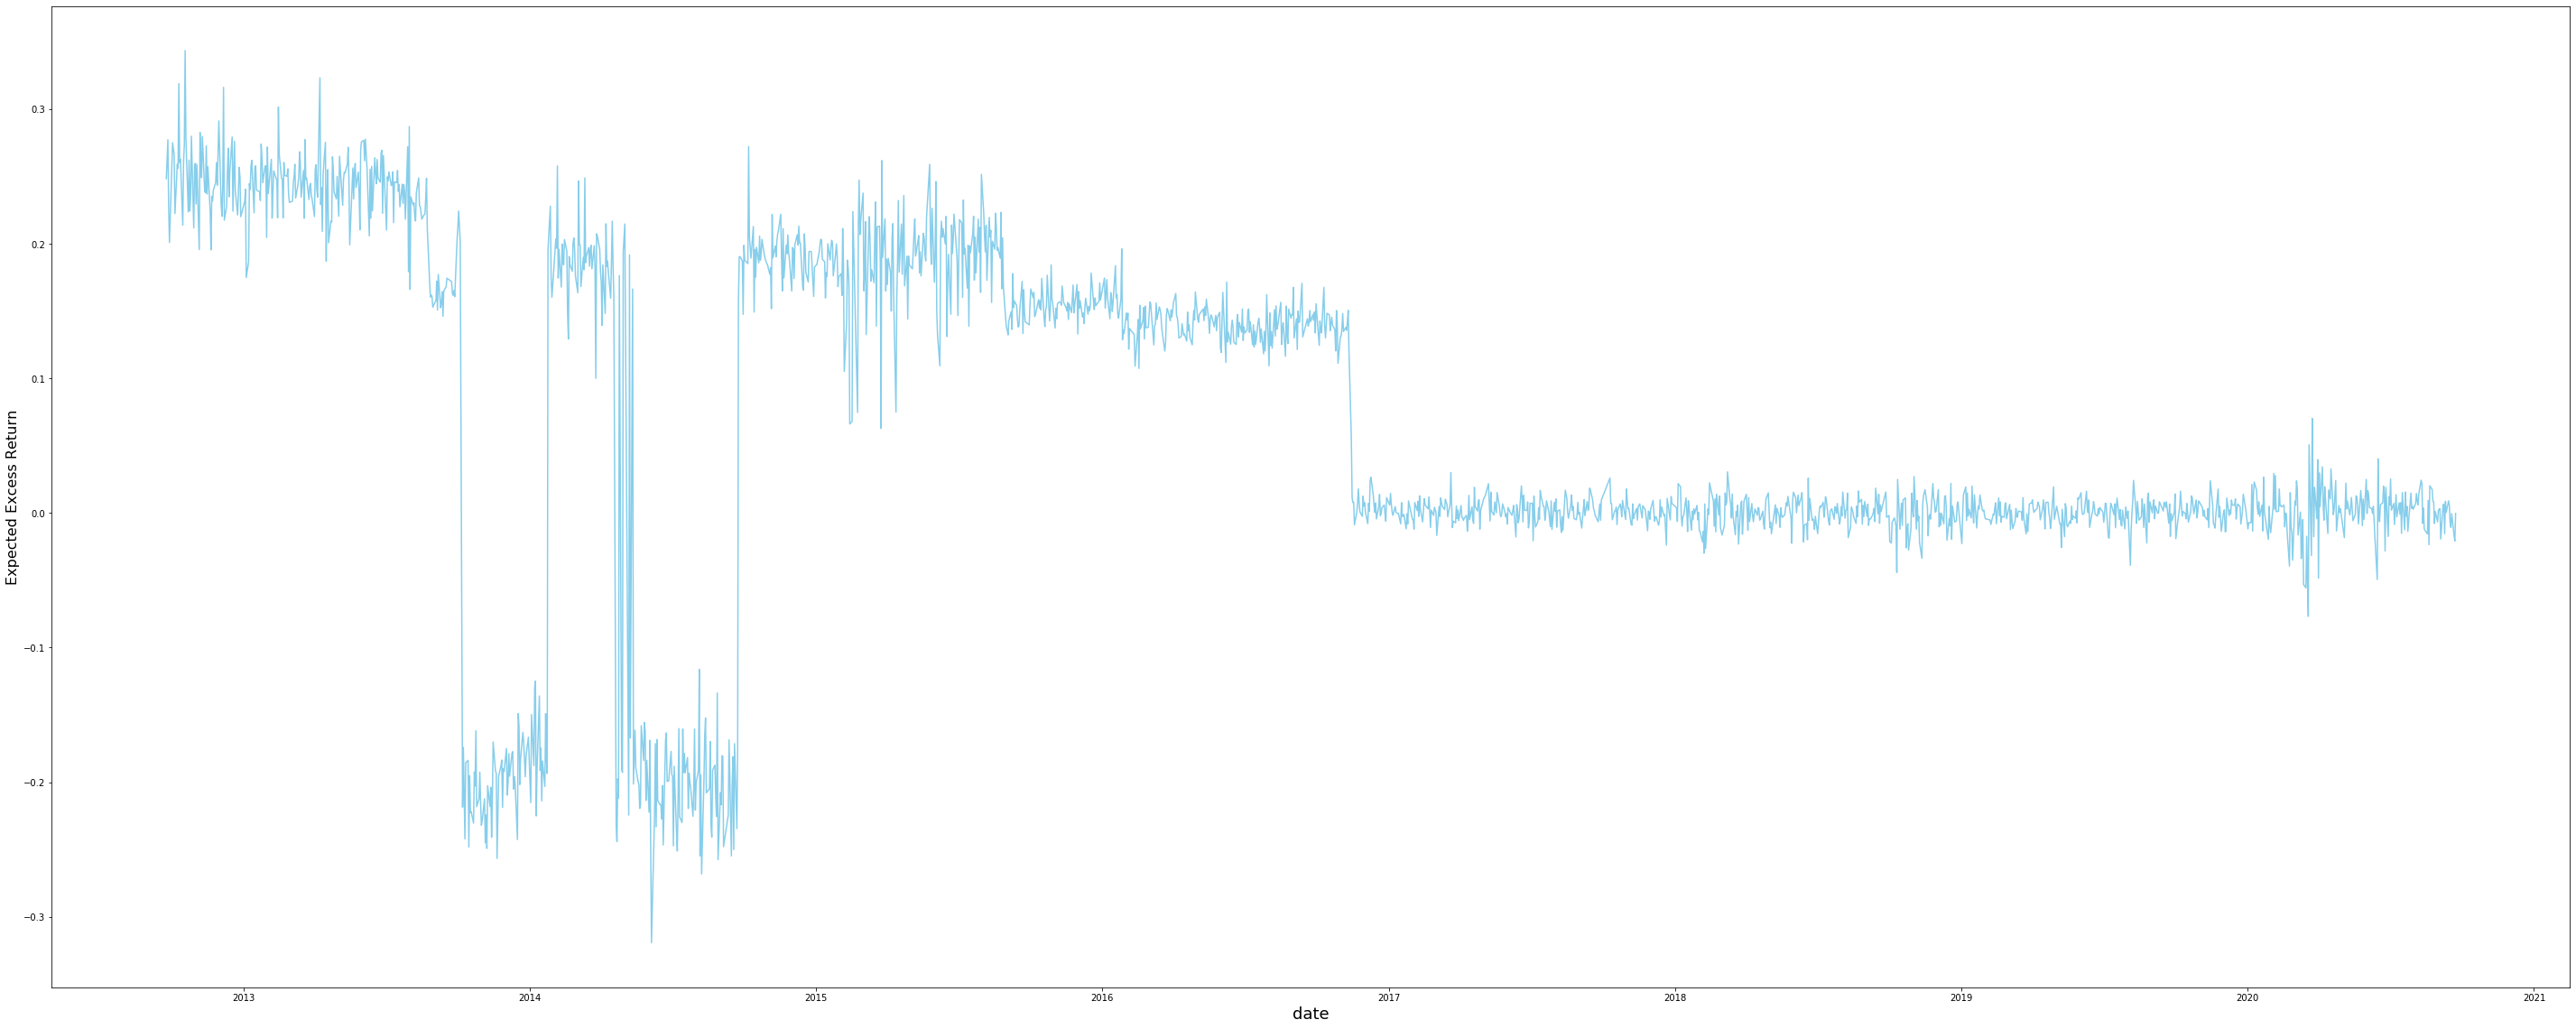

sharpe_ratio: 0.5092464194929704


In [31]:
X = None
y = None
def dantzig_method():
    global df
    global X
    global _lambda
    global y
    EER_dantzig = []
    for i in range(len(test_date_list)):
        print(test_date_list[i])
        df = train_data(test_date_list[i])
        vcov = df.cov().values
        mu = df.mean(axis = 0)
        mu = np.array(mu.values.tolist()).reshape(-1,1)
        n = len(df)
        p = len(df.columns)
        _lambda = 1.5 # lambda는 0.5로 두었음.
        theta = np.abs( (mu.T @ np.linalg.inv(vcov) @ mu) - p/(n-p) ) / (n/(n-p))
        Rc = sigma * (1+theta)/np.sqrt(theta)
        y = np.ones((n, 1))*Rc
        X = df.values
        lasso = linear_model.Lasso(alpha=0)
        _coef = lasso.fit(X, y).coef_
        cons = [{'type': 'ineq', 'fun': constraint1}]
        res = minimize(weight_dantzig, _coef, constraints = cons, options = {'maxiter' : 3})
        #res = minimize(weight_dantzig, _coef, constraints = cons)
        #print(res.success)
        w = res.x
        w = w/w.sum()
        test_data = data.loc[test_date_list[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_dantzig.append(er)
    return np.array(EER_dantzig)

eer_dantzig = dantzig_method()
eer_dantzig = eer_dantzig.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list, eer_dantzig, color = 'skyblue')
plt.show()
sharpe_ratio_dantzig = eer_dantzig.mean()/eer_dantzig.std()
print('sharpe_ratio:', sharpe_ratio_dantzig)

In [32]:
print('sharpe ratio of LASSO:', sharpe_ratio_lasso)
print('sharpe ratio of Plug:', sharpe_ratio_plug)
print('sharpe ratio of Equal:', sharpe_ratio_equal)
print('sharpe ratio of kospi:', sharpe_ratio_kospi)
print('sharpe ratio of Shrinkage:', sharpe_ratio_shrink)
print('sharpe ratio of Dantzig:', sharpe_ratio_dantzig)

sharpe ratio of LASSO: 0.7214954921950096
sharpe ratio of Plug: 0.15578179516202154
sharpe ratio of Equal: 0.5242426079133936
sharpe ratio of kospi: 0.008281647488673936
sharpe ratio of Shrinkage: 0.9313169869109026
sharpe ratio of Dantzig: 0.5092464194929704


In [33]:
data_cd2

,rate
Date,
2009-01-02,0.000108
2009-01-05,0.000107
2009-01-06,0.000107
2009-01-07,0.000107
2009-01-08,0.000089
...,...
2020-09-17,0.000017
2020-09-18,0.000017
2020-09-21,0.000017


In [34]:
cd = data_cd2.loc[test_date_list].to_numpy().reshape(-1)
cd_kospi = data_cd2.loc[eer_kospi_df.index]
cd_kospi = cd_kospi.to_numpy().reshape(-1)
cd_kospi

array([8.54794521e-05, 8.52054795e-05, 8.49315068e-05, ...,
       1.72602740e-05, 1.72602740e-05, 1.72602740e-05])

In [35]:
er_lasso = eer_lasso + cd
er_plug = eer_plug + cd
er_equal = eer_equal + cd
er_kospi = eer_kospi + cd_kospi
er_shrink = eer_shrink + cd
er_dantzig = eer_dantzig + cd

In [36]:
cum_er_lasso = np.cumsum(er_lasso)
cum_er_plug = np.cumsum(er_plug)
cum_er_equal = np.cumsum(er_equal)
cum_er_kospi = np.cumsum(er_kospi)
cum_er_shrink = np.cumsum(er_shrink)
cum_er_dantzig = np.cumsum(er_dantzig)

In [37]:
er_lasso
er_plug
er_equal
er_kospi
er_shrink
er_dantzig

array([ 0.11045667,  0.11031366,  0.11020853, ..., -0.02133138,
       -0.01550987,  0.01185251])

array([ 0.11469442,  0.11469392,  0.1146936 , ..., -0.00358664,
       -0.04940868,  0.16062324])

array([ 0.01941916,  0.00808749,  0.00204668, ..., -0.01958523,
       -0.01645997, -0.00290049])

array([ 0.00061944, -0.00593775, -0.00543924, ..., -0.00956679,
       -0.02404157,  0.00029579])

array([0.10936597, 0.10944899, 0.10960904, ..., 0.00652984, 0.00704164,
       0.0270557 ])

array([ 0.24841718,  0.2622522 ,  0.27730103, ..., -0.01672746,
       -0.02092811, -0.00034242])

<Figure size 3600x1440 with 0 Axes>

Text(0.5, 1.0, 'Expected return')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

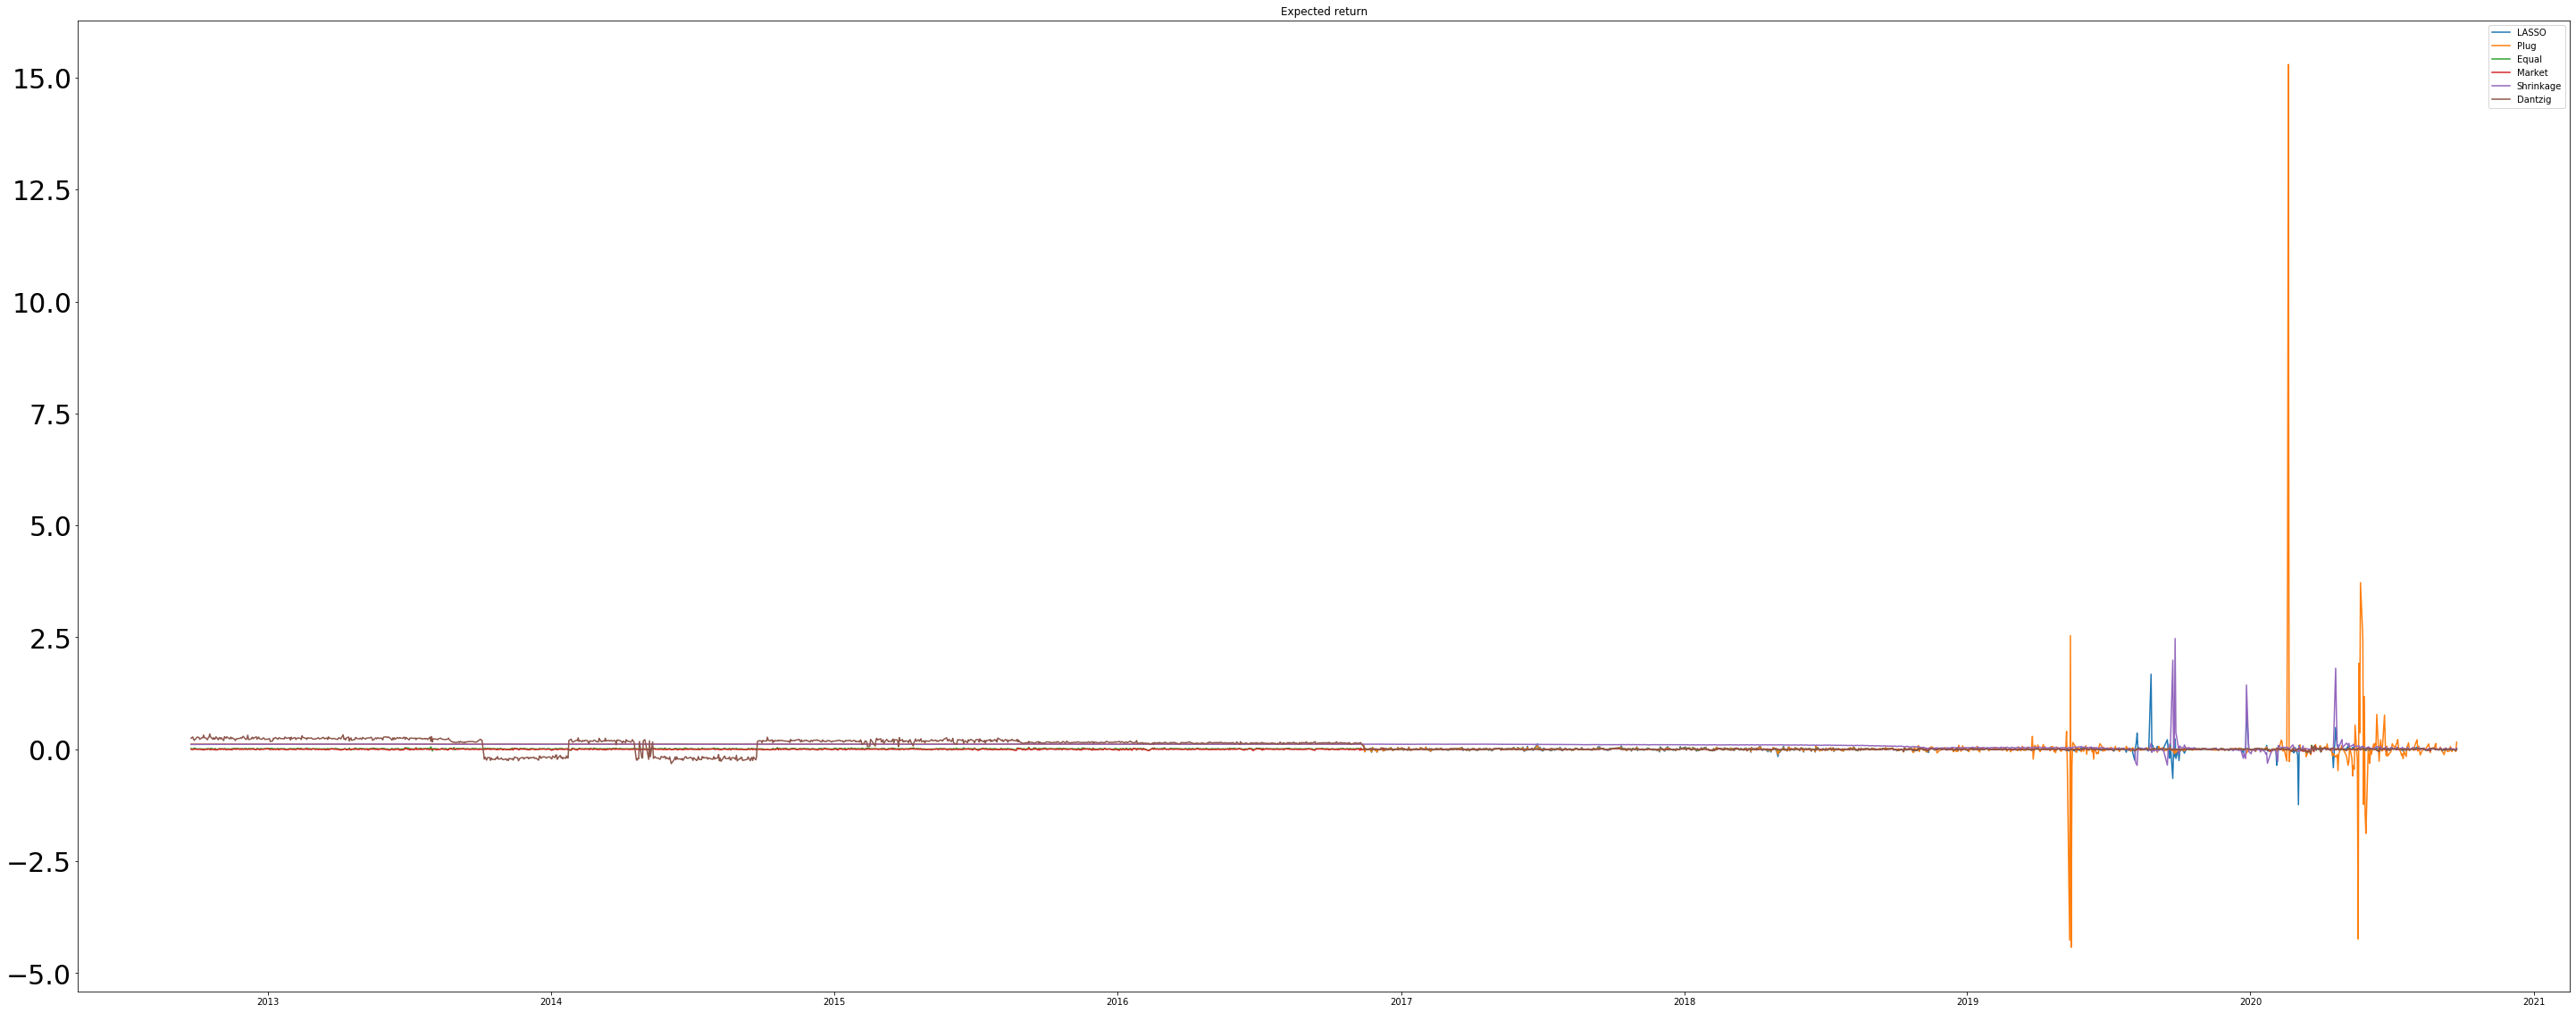

In [38]:
plt.figure(figsize=(50,20))
plt.title("Expected return")
plt.yticks(fontsize=30)
plt.plot(test_date_list, er_lasso)
plt.plot(test_date_list, er_plug)
plt.plot(test_date_list, er_equal)
plt.plot(eer_kospi_df.index, er_kospi) #kospi는 length가 다름.
plt.plot(test_date_list, er_shrink)
plt.plot(test_date_list, er_dantzig)
plt.legend(['LASSO', 'Plug', 'Equal', 'Market', 'Shrinkage', 'Dantzig'])
plt.show()

In [39]:
cum_er_lasso
cum_er_plug
cum_er_equal
cum_er_kospi
cum_er_shrink
cum_er_dantzig

array([1.10456671e-01, 2.20770335e-01, 3.30978866e-01, ...,
       1.17546915e+02, 1.17531405e+02, 1.17543257e+02])

array([1.14694420e-01, 2.29388340e-01, 3.44081940e-01, ...,
       1.30191746e+02, 1.30142338e+02, 1.30302961e+02])

array([ 0.01941916,  0.02750665,  0.02955332, ..., 12.66480894,
       12.64834896, 12.64544848])

array([ 0.00061944, -0.00531831, -0.01075755, ...,  0.27579655,
        0.25175498,  0.25205077])

array([1.09365975e-01, 2.18814966e-01, 3.28424003e-01, ...,
       1.80484343e+02, 1.80491385e+02, 1.80518440e+02])

array([  0.24841718,   0.51066937,   0.7879704 , ..., 125.3808364 ,
       125.35990829, 125.35956587])

<Figure size 3600x1440 with 0 Axes>

Text(0.5, 1.0, 'Cummulated expected excess return')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

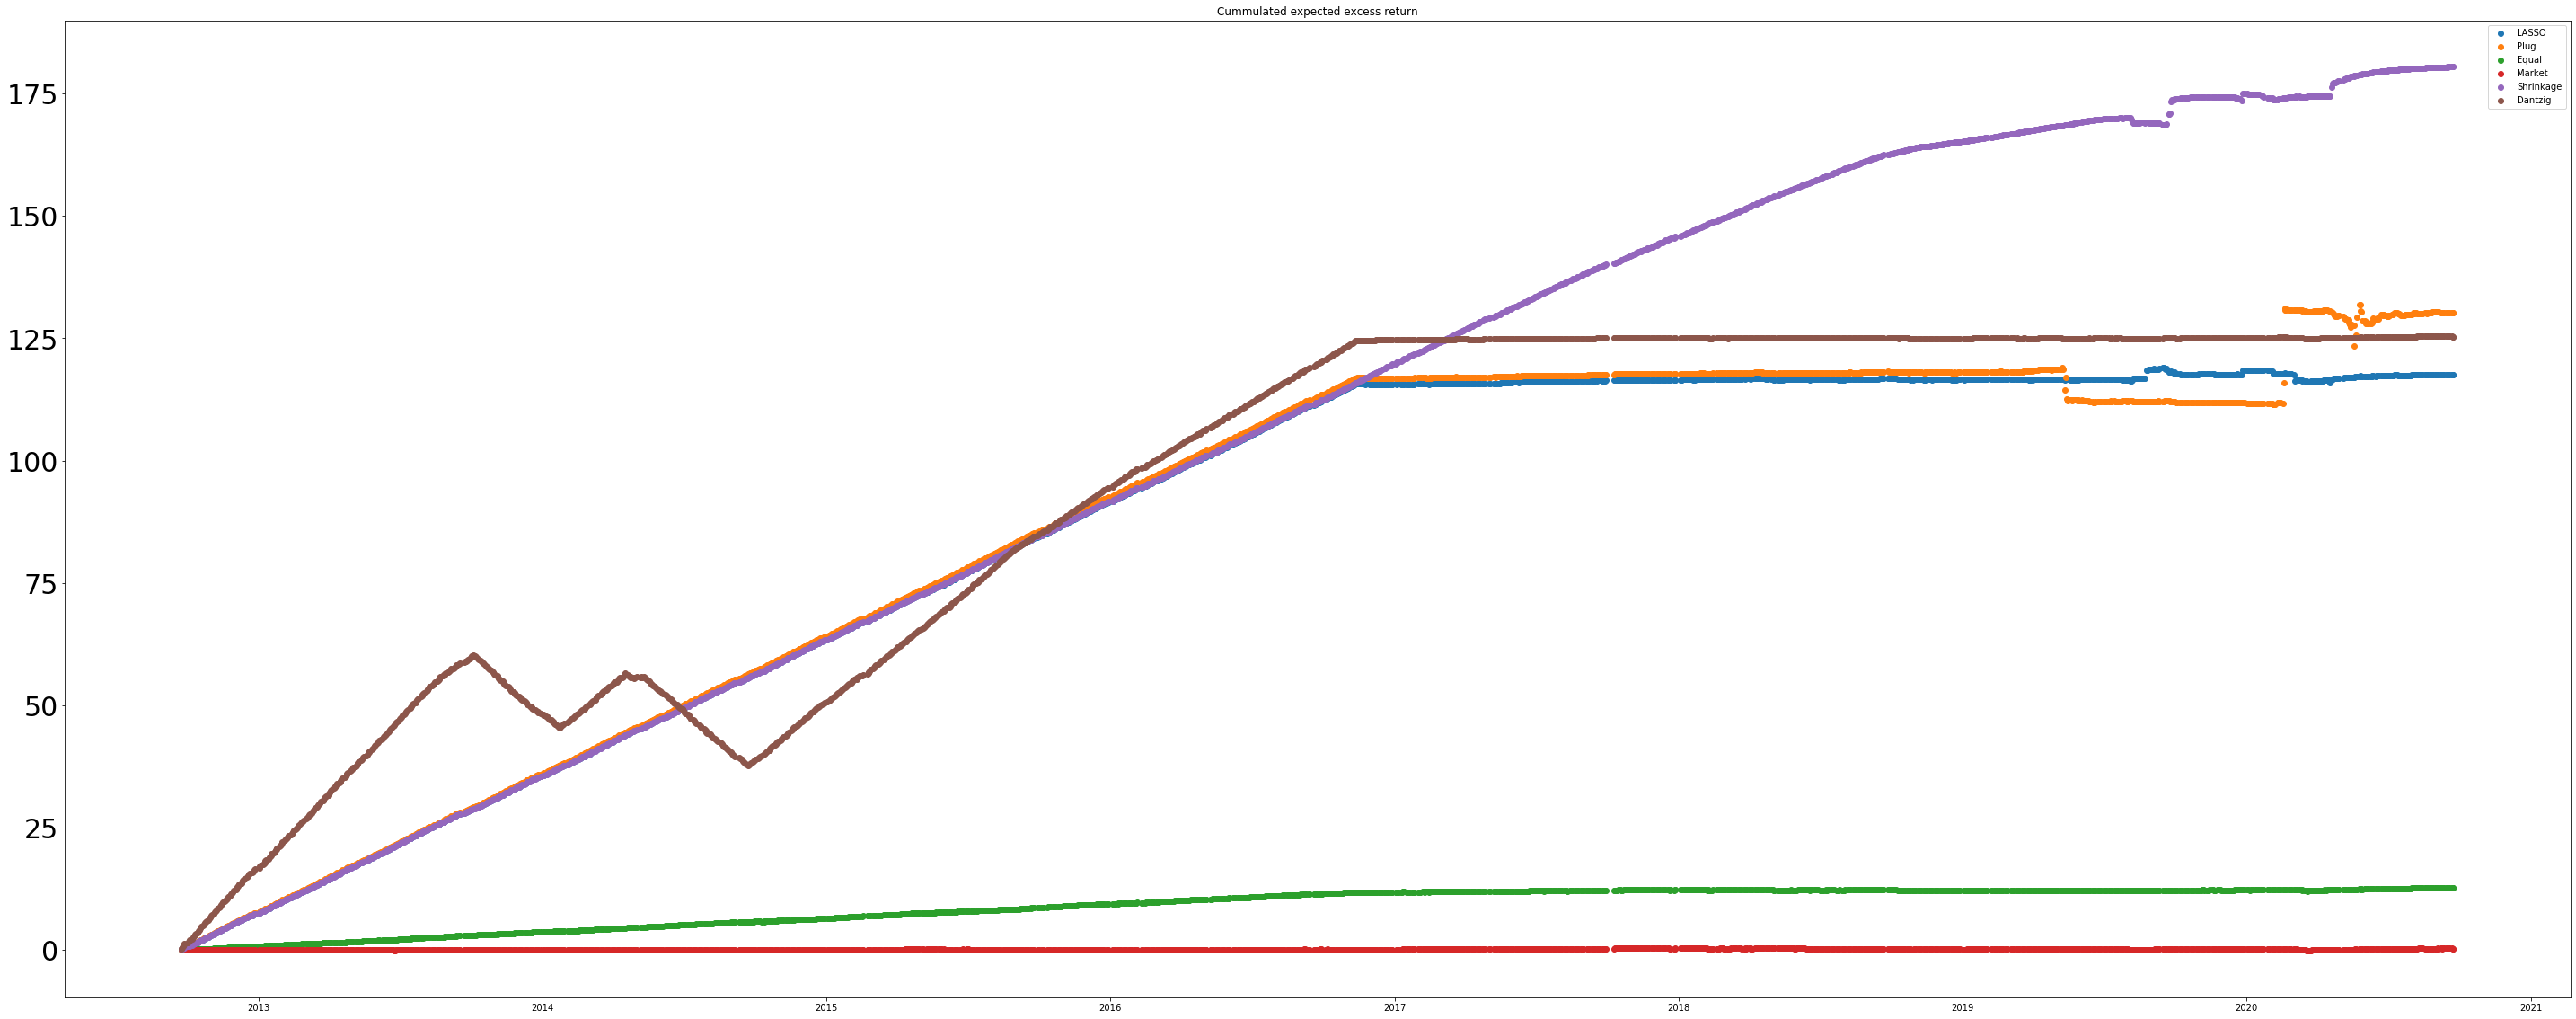

In [40]:
plt.figure(figsize=(50,20))
plt.title("Cummulated expected excess return")
plt.yticks(fontsize=30)
plt.scatter(test_date_list, cum_er_lasso)
plt.scatter(test_date_list, cum_er_plug)
plt.scatter(test_date_list, cum_er_equal)
plt.scatter(eer_kospi_df.index, cum_er_kospi)
plt.scatter(test_date_list, cum_er_shrink)
plt.scatter(test_date_list, cum_er_dantzig)
plt.legend(['LASSO', 'Plug', 'Equal', 'Market', 'Shrinkage', 'Dantzig'])
plt.show()

## 왜 이렇게 높거나 낮은 수익률이 나오는 걸까? 
- 결과적으로 높은 종목들만 골랐음 (과거에 비해 성장한 종목들만 골랐음)
- 공매가 가능하기 때문에 높은 레버리지 수익 가능 (하지만 큰 손해를 볼 수도 있음)
- Weight에 제한을 두지 않았음. (무한대로 성장가능)
- 거래비용을 고려하지 않았음.
- 슬리피지를 고려하지 않았음.

## 1-(2) 시간을 '주' 단위로 하고 나머지는 같은 조건으로 진행.

In [41]:
data2 = data.copy()
data2

,005930.KS,051910.KS,005380.KS,035420.KS,017670.KS,207940.KS,068270.KS,035720.KS,006400.KS,051900.KS
Date,,,,,,,,,,
2010-09-24,-0.023420,-0.019726,0.037787,0.019978,-0.000073,0.114619,0.009590,0.009279,-0.000073,-0.009877
2010-09-27,-0.009302,-0.013909,-0.000073,0.038860,0.008977,0.114619,0.056018,0.005232,-0.022191,0.012167
2010-09-28,-0.013406,-0.009404,-0.031522,0.009429,0.008896,0.114619,0.004460,-0.001397,0.003117,-0.017251
2010-09-29,0.035527,0.039749,-0.029248,-0.038631,0.011762,0.114619,-0.025276,0.019600,0.012586,0.014669
2010-09-30,0.006383,0.001427,0.006485,-0.037625,0.008712,0.114619,0.036382,0.023035,-0.019121,0.026403
...,...,...,...,...,...,...,...,...,...,...
2020-09-17,-0.024915,-0.063101,0.002704,-0.021417,0.004090,-0.024807,-0.018709,-0.016060,-0.008956,0.001310
2020-09-18,-0.003384,0.032022,-0.016456,-0.008372,-0.000017,0.001303,-0.000017,0.005359,0.016678,0.005274
2020-09-21,-0.001705,-0.060360,0.021842,-0.020357,-0.014465,-0.024050,-0.045639,-0.023069,-0.015590,-0.012629


In [42]:
data2 = data2.resample('w').sum()

In [43]:
def train_data2(test_date):
    _start_date = test_date + relativedelta(years = -4)
    _end_date = test_date
    df = data[(data.index >= _start_date) & (data.index <= _end_date)]
    return df

In [44]:
date_list2 = data2.index
six_years_ago = today + relativedelta(years = -6)
test_date_list2 = date_list2[date_list2 >= six_years_ago]
test_date_list2

DatetimeIndex(['2014-09-28', '2014-10-05', '2014-10-12', '2014-10-19',
               '2014-10-26', '2014-11-02', '2014-11-09', '2014-11-16',
               '2014-11-23', '2014-11-30',
               ...
               '2020-07-26', '2020-08-02', '2020-08-09', '2020-08-16',
               '2020-08-23', '2020-08-30', '2020-09-06', '2020-09-13',
               '2020-09-20', '2020-09-27'],
              dtype='datetime64[ns]', name='Date', length=314, freq='W-SUN')

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

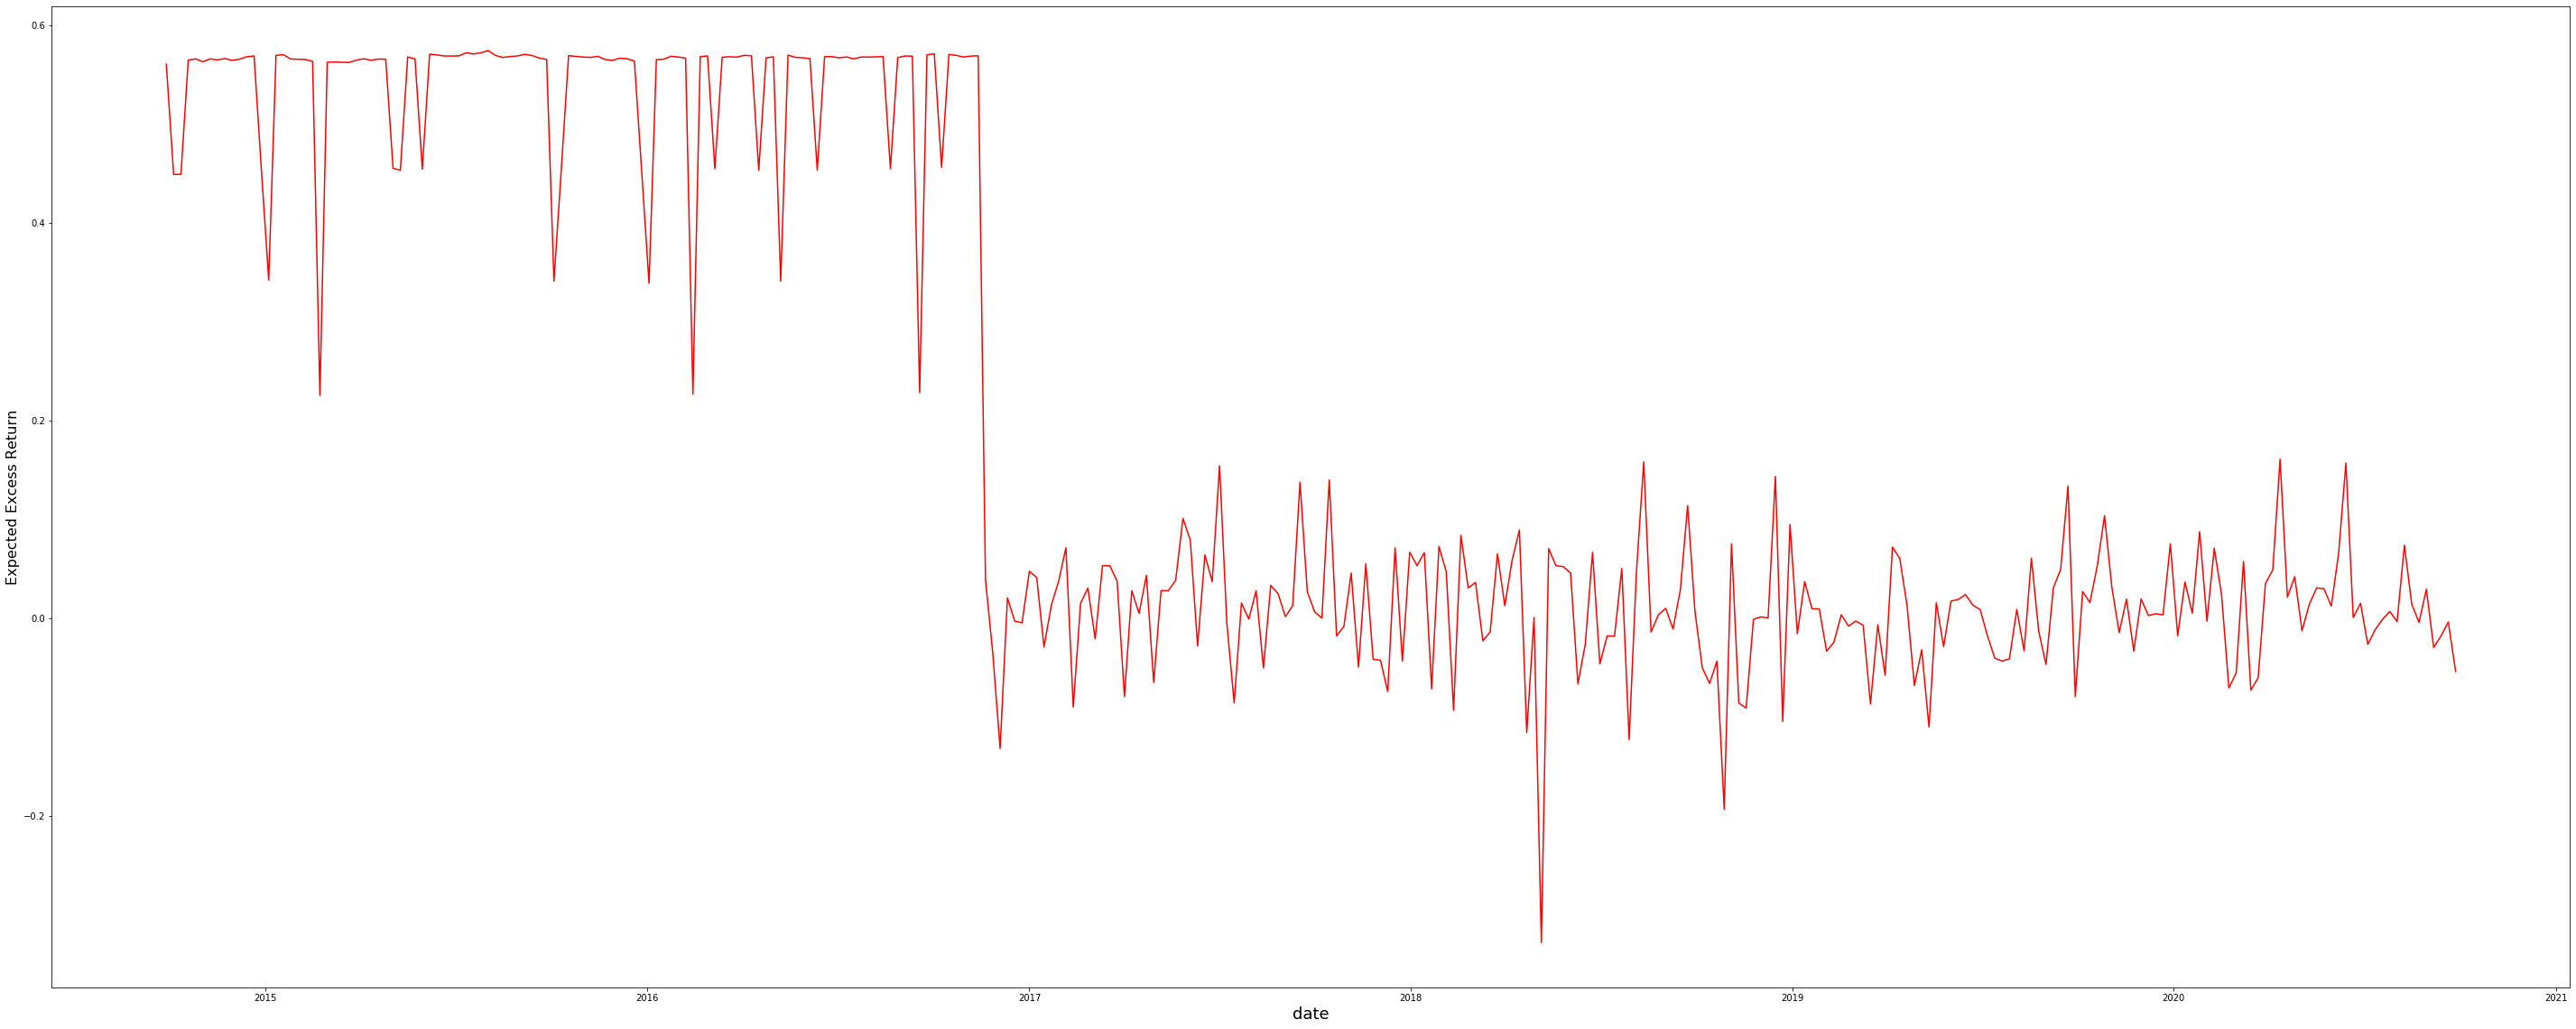

0.19631369021568676 0.262069386621542
sharpe_ratio: 0.7490905089925137


In [45]:
def weight_lasso(x):
    global df
    rc = x[0] # scalar
    w = x[1:] # (p, 1)
    wr = df.to_numpy() @ w
    return (rc - wr.mean())**2
df = None
def Lasso_method2():
    global df
    EER_lasso = []
    for i in range(len(test_date_list2)): 
        #print(test_date_list[i])
        df = train_data2(test_date_list2[i])
        vcov = df.cov().values
        mu = df.mean(axis = 0)
        mu = np.array(mu.values.tolist()).reshape(-1,1)
        n = len(df)
        p = len(df.columns)
        theta = np.abs( (mu.T @ np.linalg.inv(vcov) @ mu) - p/(n-p) ) / (n/(n-p))
        Rc = sigma * (1+theta)/np.sqrt(theta)
        y = np.ones((n, 1)) * Rc
        lasso = linear_model.Lasso(alpha=0)
        _coef = lasso.fit(df.to_numpy(), y).coef_
        Rc = Rc.reshape(-1)
        bnds1 = [(Rc[0], Rc[0])] + [(None, None) for x in range(p)]
        _input = np.concatenate((Rc, _coef), axis = 0)
        res = minimize(weight_lasso, _input.tolist(), bounds = bnds1)
        w = res.x[1:]
        w = w/w.sum()
        test_data = data2.loc[test_date_list2[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_lasso.append(er)
    return np.array(EER_lasso)

eer_lasso2 = Lasso_method2()
eer_lasso2 = eer_lasso2.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list2, eer_lasso2, color = 'red')
plt.show()
sharpe_ratio_lasso2 = eer_lasso2.mean()/eer_lasso2.std()
print(eer_lasso2.mean(), eer_lasso2.std())
print('sharpe_ratio:', sharpe_ratio_lasso2)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

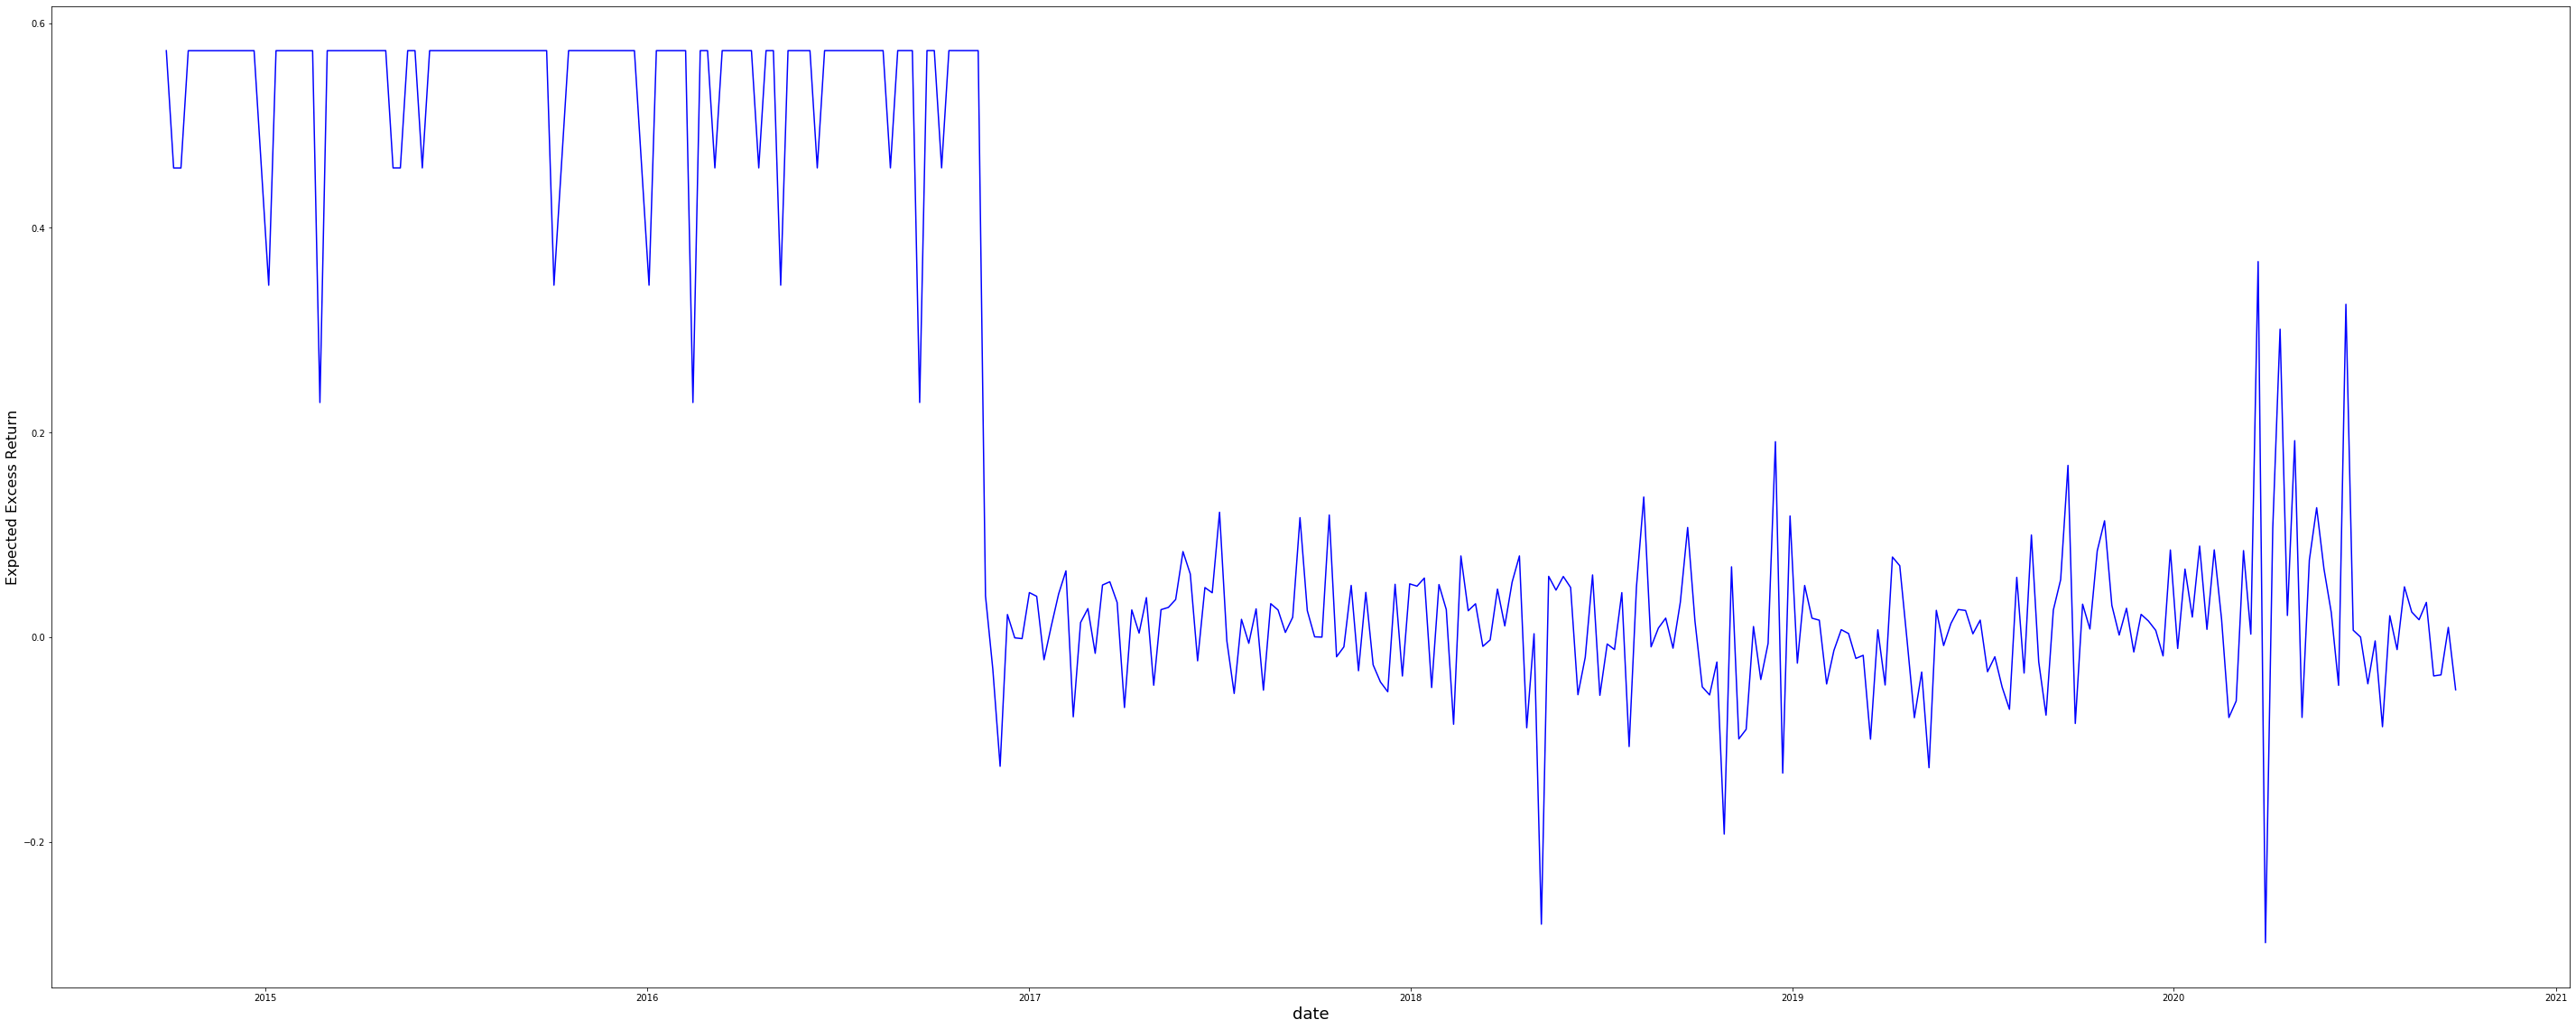

0.20130917186885752 0.2650594996016009
sharpe_ratio: 0.7594867272119518


In [46]:
def plug_in_method2():
    EER_plug = []
    for i in range(len(test_date_list2)):
        df = train_data2(test_date_list2[i]) # (n, p)
        vcov = df.cov().values # (p, p)
        mu = df.mean(axis = 0) # (p)
        mu = np.array(mu.values.tolist()).reshape(-1,1) # (p, 1)
        w = sigma / np.sqrt( mu.T @ np.linalg.inv(vcov) @ mu ) * ( np.linalg.inv(vcov) @ mu )
        # (1, p) @ (p, p) @ (p, 1) // (p, p) @ (p, 1)
        w = w/w.sum()
        test_data = data2.loc[test_date_list2[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_plug.append(er)
    return np.array(EER_plug)

eer_plug2= plug_in_method2()
eer_plug2 = eer_plug2.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list2, eer_plug2, color = 'blue')
plt.show()
sharpe_ratio_plug2 = eer_plug2.mean()/eer_plug2.std()
print(eer_plug2.mean(), eer_plug2.std())
print('sharpe_ratio:', sharpe_ratio_plug2)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

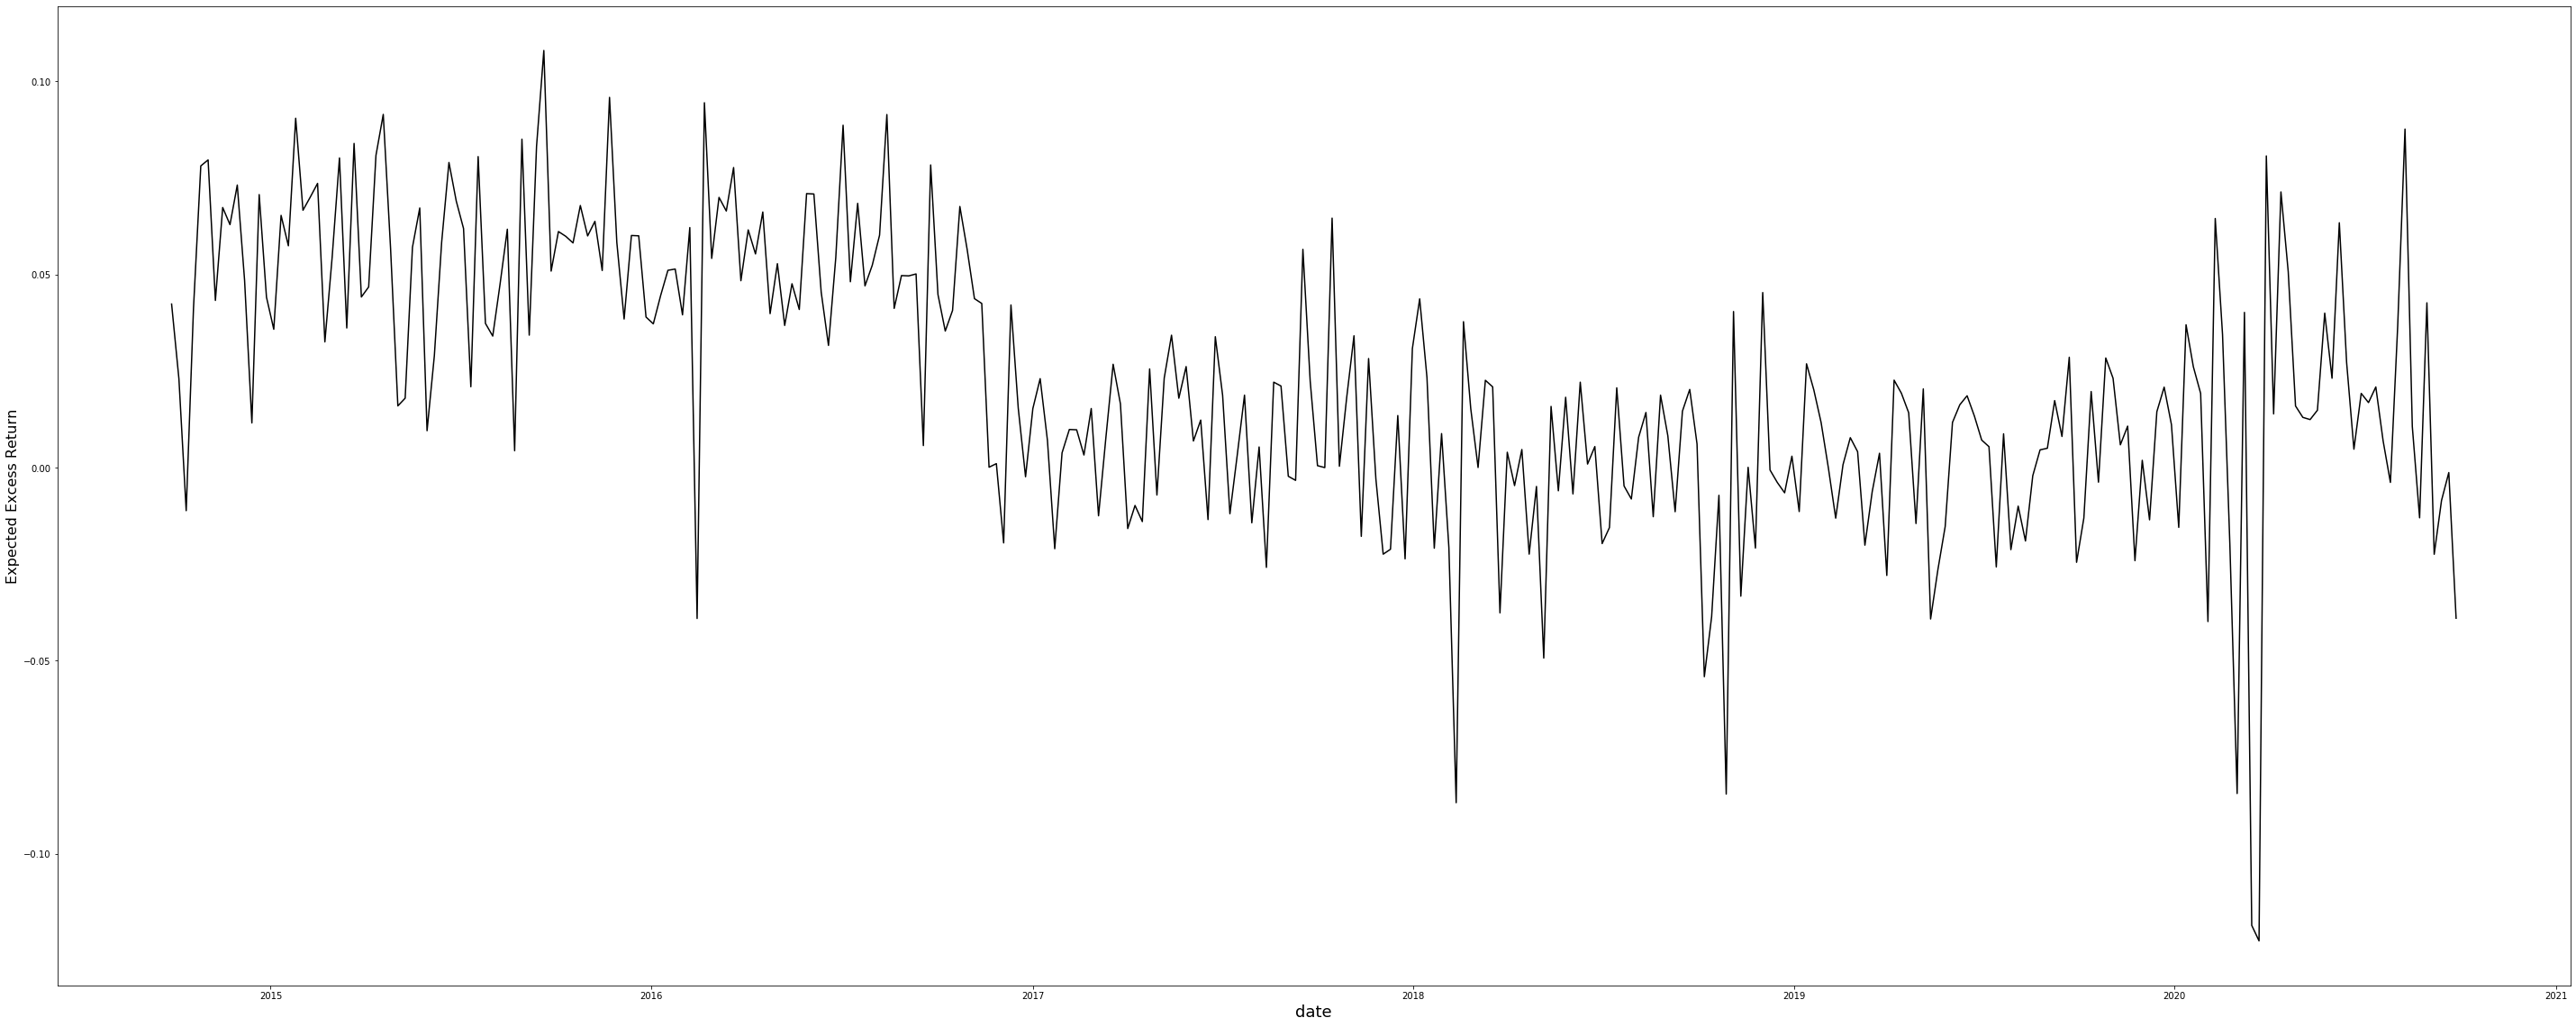

sharpe_ratio: 0.6155435585387034


In [47]:
def equal_weight_method2():
    EER_equal = []
    for i in range(len(test_date_list2)):
        df = train_data2(test_date_list2[i])
        w = np.ones(len(df.columns)) * (1/len(df.columns))
        test_data = data2.loc[test_date_list2[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_equal.append(er)
    return np.array(EER_equal)

eer_equal2= equal_weight_method2()
eer_equal2 = eer_equal2.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list2, eer_equal2, color = 'black')
plt.show()
sharpe_ratio_equal2 = eer_equal2.mean()/eer_equal2.std()
print('sharpe_ratio:', sharpe_ratio_equal2)

<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

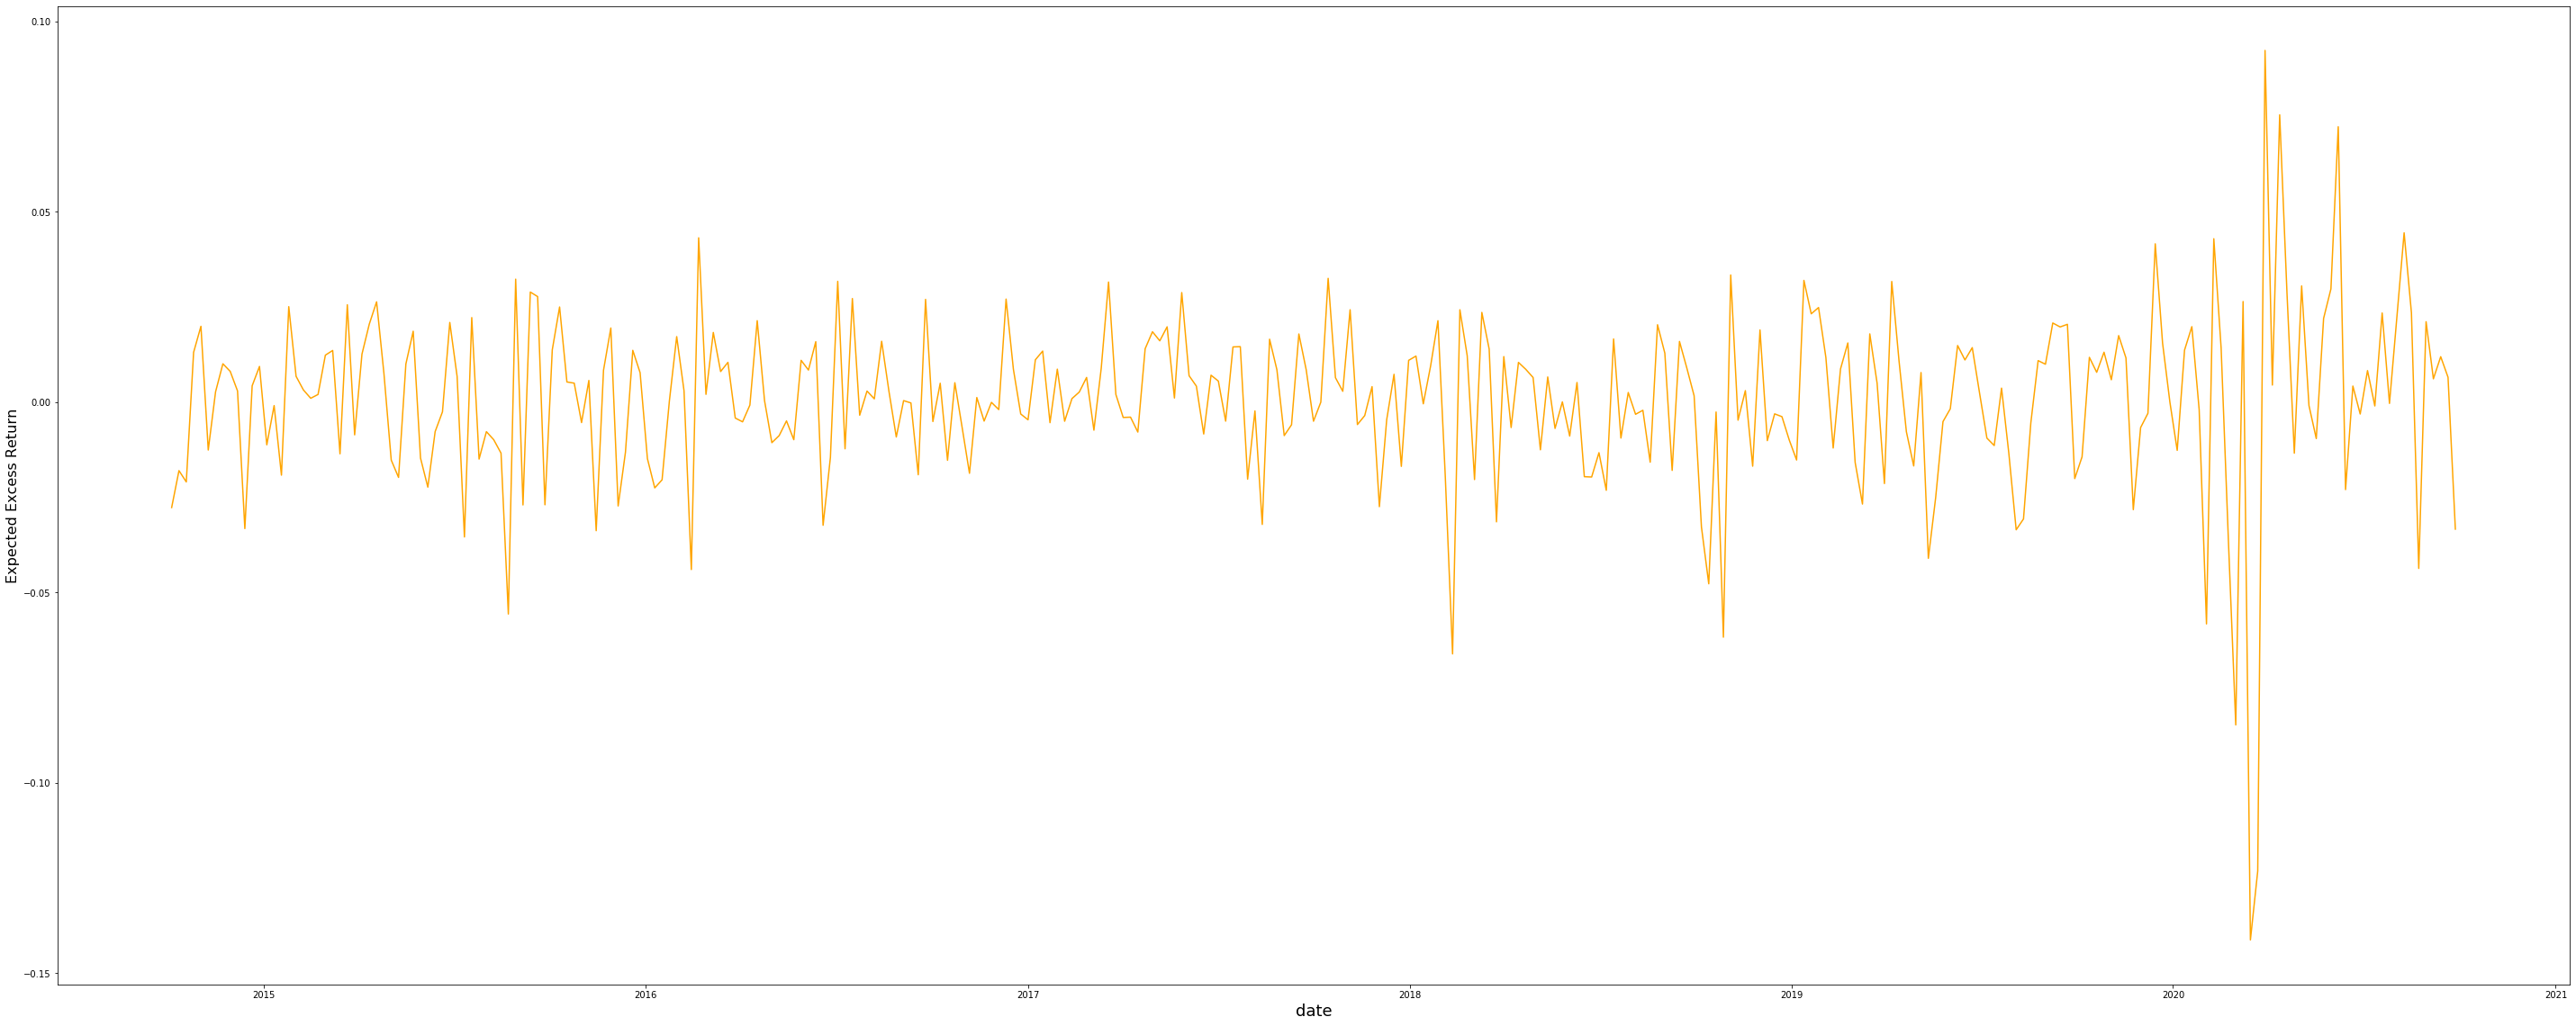

sharpe_ratio: 0.019168565679484682


In [48]:
# KOSPI
eer_kospi_df2 = EER_kospi.loc[test_date_list2[0]:].resample('w').sum()
eer_kospi2 = eer_kospi_df2.to_numpy().reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(eer_kospi_df2.index, eer_kospi2, color = 'orange')
plt.show()
sharpe_ratio_kospi2 = eer_kospi2.mean()/eer_kospi2.std()
print('sharpe_ratio:', sharpe_ratio_kospi2)

2014-09-28 00:00:00
2014-10-05 00:00:00
2014-10-12 00:00:00
2014-10-19 00:00:00
2014-10-26 00:00:00
2014-11-02 00:00:00
2014-11-09 00:00:00
2014-11-16 00:00:00
2014-11-23 00:00:00
2014-11-30 00:00:00
2014-12-07 00:00:00
2014-12-14 00:00:00
2014-12-21 00:00:00
2014-12-28 00:00:00
2015-01-04 00:00:00
2015-01-11 00:00:00
2015-01-18 00:00:00
2015-01-25 00:00:00
2015-02-01 00:00:00
2015-02-08 00:00:00
2015-02-15 00:00:00
2015-02-22 00:00:00
2015-03-01 00:00:00
2015-03-08 00:00:00
2015-03-15 00:00:00
2015-03-22 00:00:00
2015-03-29 00:00:00
2015-04-05 00:00:00
2015-04-12 00:00:00
2015-04-19 00:00:00
2015-04-26 00:00:00
2015-05-03 00:00:00
2015-05-10 00:00:00
2015-05-17 00:00:00
2015-05-24 00:00:00
2015-05-31 00:00:00
2015-06-07 00:00:00
2015-06-14 00:00:00
2015-06-21 00:00:00
2015-06-28 00:00:00
2015-07-05 00:00:00
2015-07-12 00:00:00
2015-07-19 00:00:00
2015-07-26 00:00:00
2015-08-02 00:00:00
2015-08-09 00:00:00
2015-08-16 00:00:00
2015-08-23 00:00:00
2015-08-30 00:00:00
2015-09-06 00:00:00


<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

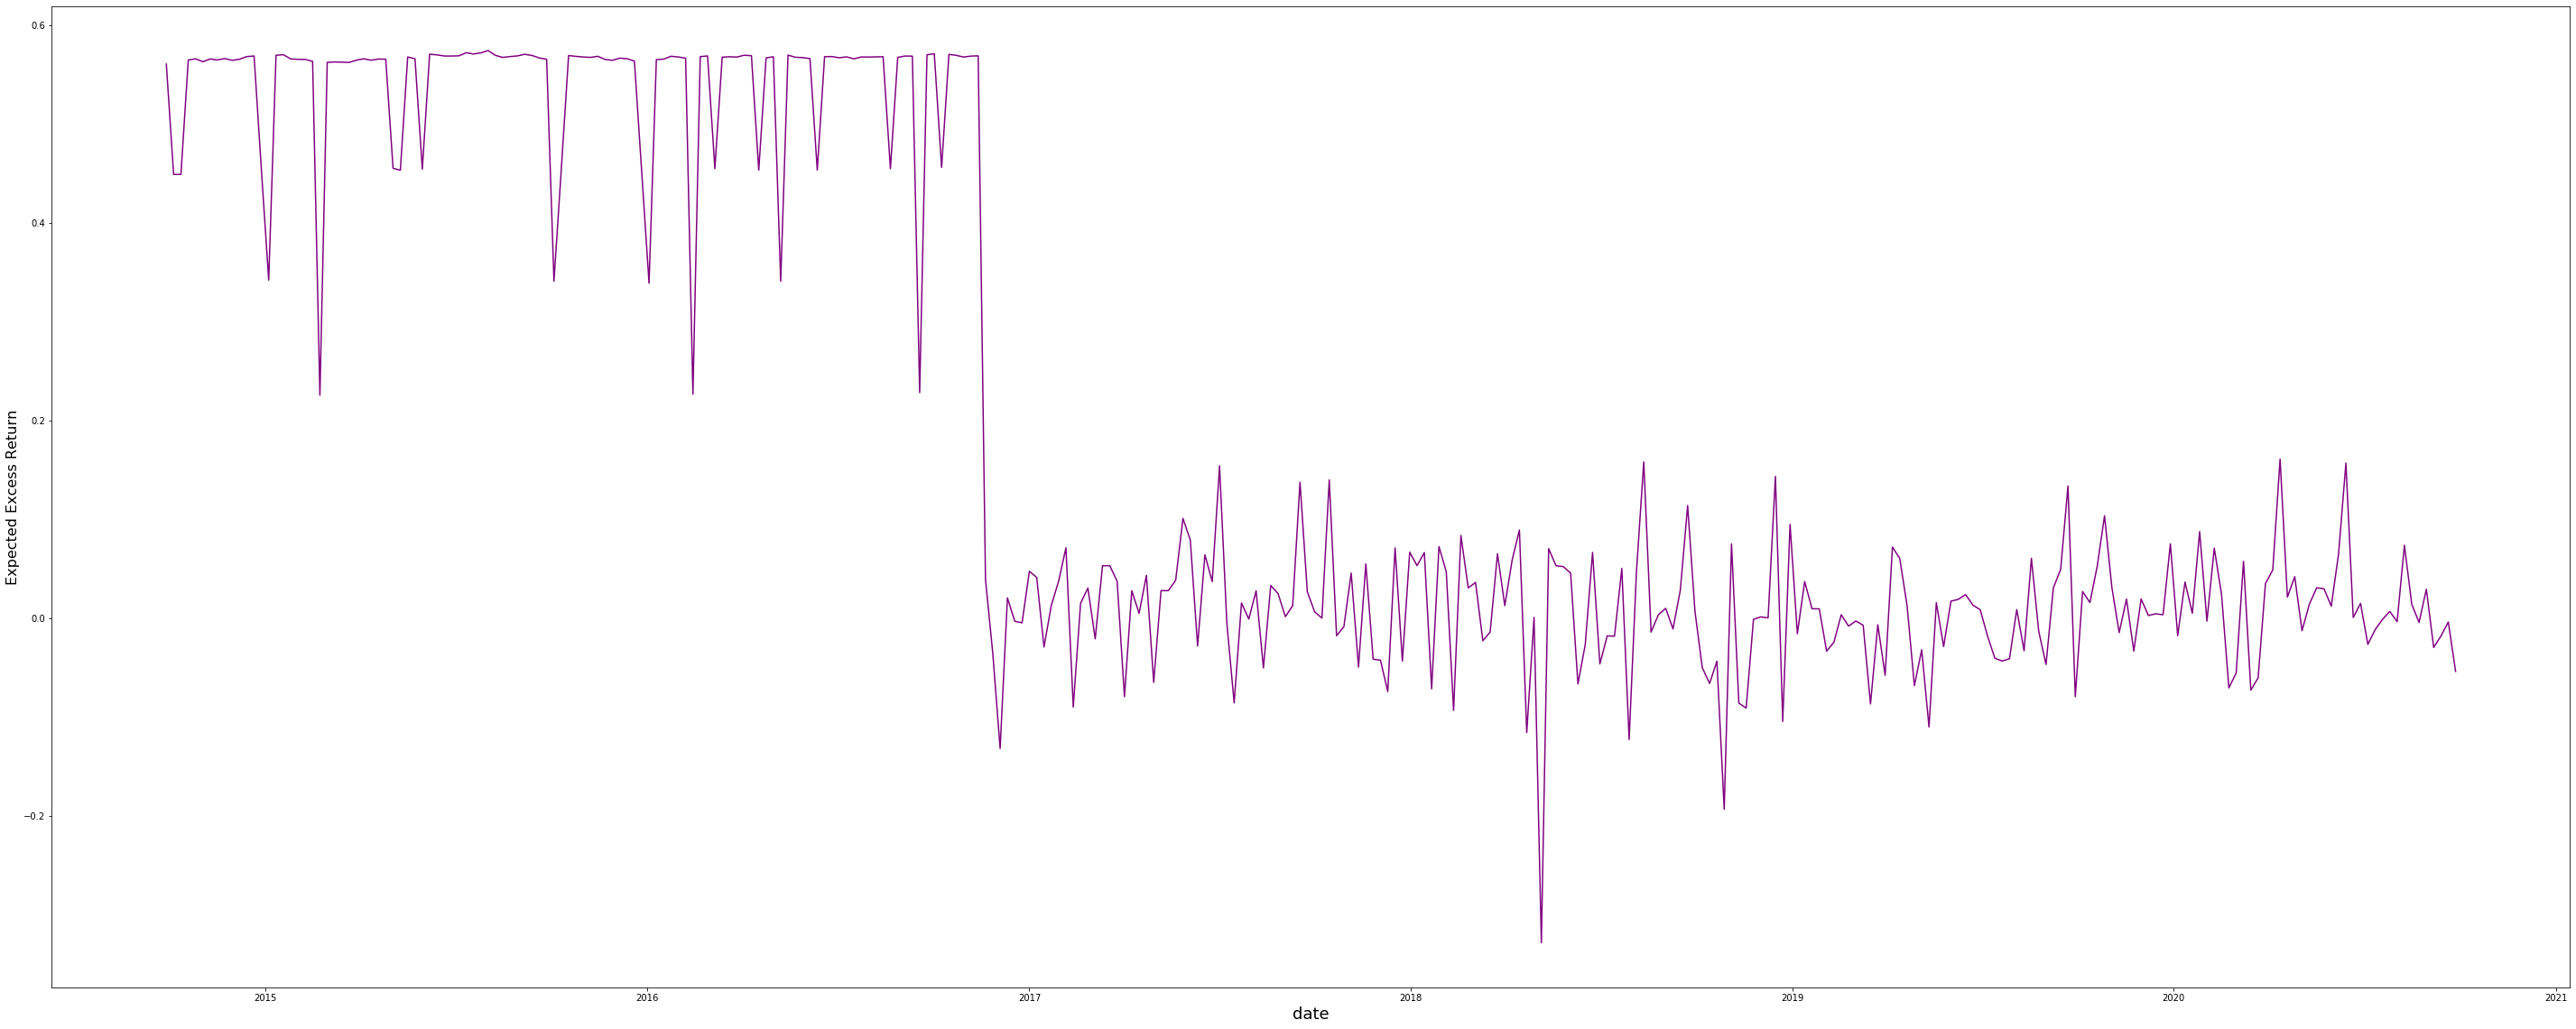

sharpe_ratio: 0.7490908760136371


In [49]:
def Shrinkage_method2():
    EER_shrink = []
    for i in range(len(test_date_list2)):
        print(test_date_list2[i])
        df = train_data2(test_date_list2[i]) # (n, p)
        vcov = df.cov().values # (p, p)
        mu = df.mean(axis = 0) # (p)
        mu = np.array(mu.values.tolist()).reshape(-1,1) # (p, 1)
        n = len(df)
        p = len(df.columns)

        F = np.diag(vcov).sum()/p * np.eye(p)
        up = 0
        for j in range(n):
            X = df.iloc[j].values
            temp_up = X @ X.T - vcov
            temp_up = (temp_up**2).sum()
            up += temp_up
        vcov2 = vcov @ vcov
        down = n**2 * ( np.diag(vcov2).sum() - np.diag(vcov).sum()**2/p )
        pi = min(up/down, 1)
        sigma_s = (1-pi)*vcov + pi*F
        w = sigma/np.sqrt( mu.T @ sigma_s @ mu ) * (np.linalg.inv(sigma_s) @ mu)
        w = w/w.sum()
        test_data = data2.loc[test_date_list2[i]]
        test_data = test_data.to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_shrink.append(er)
    return np.array(EER_shrink)

eer_shrink2 = Shrinkage_method2()
eer_shrink2 = eer_shrink2.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list2, eer_shrink2, color = 'purple')
plt.show()
sharpe_ratio_shrink2 = eer_shrink2.mean()/eer_shrink2.std()
print('sharpe_ratio:', sharpe_ratio_shrink2)

In [ ]:
X = None
y = None
df = None
_lambda = None
def dantzig_method2():
    global df
    global X
    global _lambda
    global y
    EER_dantzig = []
    for i in range(len(test_date_list2)):
        print(test_date_list2[i])
        df = train_data2(test_date_list2[i])
        vcov = df.cov().values
        mu = df.mean(axis = 0)
        mu = np.array(mu.values.tolist()).reshape(-1,1)
        n = len(df)
        p = len(df.columns)
        _lambda = 1.5 # lambda는 0.5로 두었음.
        theta = np.abs( (mu.T @ np.linalg.inv(vcov) @ mu) - p/(n-p) ) / (n/(n-p))
        Rc = sigma * (1+theta)/np.sqrt(theta)
        y = np.ones((n, 1))*Rc
        X = df.values
        lasso = linear_model.Lasso(alpha=0)
        _coef = lasso.fit(X, y).coef_
        cons = [{'type': 'ineq', 'fun': constraint1}]
        res = minimize(weight_dantzig, _coef, constraints = cons, options = {'maxiter' : 3})
        #res = minimize(weight_dantzig, _coef, constraints = cons)
        #print(res.success)
        w = res.x
        w = w/w.sum()
        test_data = data2.loc[test_date_list2[i]].to_numpy().reshape(-1, 1).T
        w_2d = w.reshape(-1, 1)
        er = test_data @ w_2d
        EER_dantzig.append(er)
    return np.array(EER_dantzig)

eer_dantzig2 = dantzig_method2()
eer_dantzig2 = eer_dantzig2.reshape(-1)
plt.figure(figsize=(50,20))
plt.ylabel('Expected Excess Return', fontsize=16)
plt.xlabel('date', fontsize=18)
#plt.ylim(-0.5, 0.5)
plt.plot(test_date_list2, eer_dantzig2, color = 'skyblue')
plt.show()
sharpe_ratio_dantzig2 = eer_dantzig2.mean()/eer_dantzig2.std()
print('sharpe_ratio:', sharpe_ratio_dantzig2)

2014-09-28 00:00:00
2014-10-05 00:00:00
2014-10-12 00:00:00
2014-10-19 00:00:00
2014-10-26 00:00:00
2014-11-02 00:00:00
2014-11-09 00:00:00
2014-11-16 00:00:00
2014-11-23 00:00:00
2014-11-30 00:00:00
2014-12-07 00:00:00
2014-12-14 00:00:00
2014-12-21 00:00:00
2014-12-28 00:00:00
2015-01-04 00:00:00
2015-01-11 00:00:00
2015-01-18 00:00:00
2015-01-25 00:00:00
2015-02-01 00:00:00
2015-02-08 00:00:00
2015-02-15 00:00:00
2015-02-22 00:00:00
2015-03-01 00:00:00
2015-03-08 00:00:00
2015-03-15 00:00:00
2015-03-22 00:00:00
2015-03-29 00:00:00
2015-04-05 00:00:00
2015-04-12 00:00:00
2015-04-19 00:00:00
2015-04-26 00:00:00
2015-05-03 00:00:00
2015-05-10 00:00:00
2015-05-17 00:00:00
2015-05-24 00:00:00
2015-05-31 00:00:00
2015-06-07 00:00:00
2015-06-14 00:00:00
2015-06-21 00:00:00
2015-06-28 00:00:00
2015-07-05 00:00:00
2015-07-12 00:00:00
2015-07-19 00:00:00
2015-07-26 00:00:00
2015-08-02 00:00:00
2015-08-09 00:00:00
2015-08-16 00:00:00
2015-08-23 00:00:00
2015-08-30 00:00:00
2015-09-06 00:00:00


<Figure size 3600x1440 with 0 Axes>

Text(0, 0.5, 'Expected Excess Return')

Text(0.5, 0, 'date')

In [ ]:
print('sharpe ratio of LASSO:', sharpe_ratio_lasso2)
print('sharpe ratio of Plug:', sharpe_ratio_plug2)
print('sharpe ratio of Equal:', sharpe_ratio_equal2)
print('sharpe ratio of kospi:', sharpe_ratio_kospi2)
print('sharpe ratio of Shrinkage:', sharpe_ratio_shrink2)
print('sharpe ratio of Dantzig:', sharpe_ratio_dantzig2)

In [ ]:
cd2 = data_cd2.resample('w').sum().loc[test_date_list2].to_numpy().reshape(-1)
cd_kospi2 = data_cd2.resample('w').sum().loc[eer_kospi_df2.index]
cd_kospi2 = cd_kospi2.to_numpy().reshape(-1)

In [ ]:
er_lasso2 = eer_lasso2 + cd2
er_plug2 = eer_plug2 + cd2
er_equal2 = eer_equal2 + cd2
er_kospi2 = eer_kospi2 + cd_kospi2
er_shrink2 = eer_shrink2 + cd2
er_dantzig2 = eer_dantzig2 + cd2
cum_er_lasso2 = np.cumsum(er_lasso2)
cum_er_plug2 = np.cumsum(er_plug2)
cum_er_equal2 = np.cumsum(er_equal2)
cum_er_kospi2 = np.cumsum(er_kospi2)
cum_er_shrink2 = np.cumsum(er_shrink2)
cum_er_dantzig2 = np.cumsum(er_dantzig2)

In [ ]:
plt.figure(figsize=(50,20))
plt.title("Expected return")
plt.yticks(fontsize=30)
plt.plot(test_date_list2, er_lasso2)
plt.plot(test_date_list2, er_plug2)
plt.plot(test_date_list2, er_equal2)
plt.plot(eer_kospi_df2.index, er_kospi2) #kospi는 length가 다름.
plt.plot(test_date_list2, er_shrink2)
plt.plot(test_date_list2, er_dantzig2)
plt.legend(['LASSO', 'Plug', 'Equal', 'Market', 'Shrinkage', 'Dantzig'])
plt.show()

In [ ]:
plt.figure(figsize=(50,20))
plt.title("Cummulated expected excess return")
plt.yticks(fontsize=30)
plt.scatter(test_date_list2, cum_er_lasso2)
plt.scatter(test_date_list2, cum_er_plug2)
plt.scatter(test_date_list2, cum_er_equal2)
plt.scatter(eer_kospi_df2.index, cum_er_kospi2)
plt.scatter(test_date_list2, cum_er_shrink2)
plt.scatter(test_date_list2, cum_er_dantzig2)
plt.legend(['LASSO', 'Plug', 'Equal', 'Market', 'Shrinkage', 'Dantzig'])
plt.show()

In [ ]:
cum_er_lasso2
cum_er_plug2
cum_er_equal2
cum_er_kospi2
cum_er_shrink2
cum_er_dantzig2

## 왜 이렇게 높은 수익률이 나오는 걸까? 
- 결과적으로 높은 종목들만 골랐음 (과거에 비해 성장한 종목들만 골랐음)
- 공매가 가능하기 때문에 높은 레버리지 수익 가능 (하지만 큰 손해를 볼 수도 있음)
- Weight에 제한을 두지 않았음. (무한대로 성장가능)
- 거래비용을 고려하지 않았음.
- 슬리피지를 고려하지 않았음.

# 2번

In [ ]:
data = pd.read_csv('./macro.csv')
data['KOSPI2 INDEX'] = np.log(data['KOSPI2 INDEX']/data['KOSPI2 INDEX'].shift(1))
data['Date'] = pd.to_datetime(data['Date'])
data

In [ ]:
six_years_ago = today + relativedelta(years = -20)
data = data[data['Date'] >= six_years_ago]
data.set_index('Date', inplace = True)
data

In [ ]:
Y = data[['KOSPI2 INDEX']]
X = data.drop(['KOSPI2 INDEX'], axis = 1)
_idx = list(X.index.values)
_col = list(X.columns)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns = _col, index = _idx)
X

In [ ]:
Y

lambda별 Lasso분석

In [ ]:
alphas = [0, 0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005,
         0.00055, 0.0006, 0.00065, 0.0007, 0.00075, 0.0008, 0.00085, 0.0009, 0.00095]
_nrow = len(alphas)//2
_ncol = len(alphas)//_nrow
fig, axs = plt.subplots(figsize = (30, 60), nrows = _nrow, ncols = _ncol)
coeff_df = pd.DataFrame()

for pos, al in enumerate(alphas):
    lasso = Lasso(alpha = al)
    lasso.fit(X, Y)
    coeff = pd.Series(data = lasso.coef_, index = X.columns)
    coeff = coeff.sort_values(ascending = False)
    colname = 'lambda:' + str(al)
    axs[pos//_ncol, pos%_ncol].set_title(colname)
    axs[pos//_ncol, pos%_ncol].set_xlim(-0.5, 0.5)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos//_ncol, pos%_ncol])
    coeff_df[colname] = coeff

lambda별로 위와 같이 변수 selection이 될 수 있다.